<a href="https://colab.research.google.com/github/elisasanzani/MachineLearningProject/blob/main/Zboson_decay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

import numpy as np
import pandas as pd
import os
import time

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import train_test_split
import seaborn as sns

np.random.seed() # shuffle random seed generator

Getting data from my GitHub.
The datasets I am using are from [CERN Open Data](http://opendata.cern.ch/record/545)

These data were selected to obtain
* **a candidate Z boson event into 2 muons**: an event was selected if there were two muons in the event with pT > 20 GeV and |eta| < 2.1 and the invariant mass of the two muons was > 60 GeV and < 120 GeV.
* **a candidate Z boson event into 2 electrons**: an event was selected if there were two electrons in the event with pT > 25 GeV and the invariant mass of the two electrons was > 60 GeV and < 120 GeV





In [ ]:
!wget https://raw.githubusercontent.com/elisasanzani/MachineLearningProject/main/Zee.csv -O Zee.csv
!wget https://raw.githubusercontent.com/elisasanzani/MachineLearningProject/main/Zmumu.csv -O Zmumu.csv

--2023-10-19 15:17:40--  https://raw.githubusercontent.com/elisasanzani/MachineLearningProject/main/Zee.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1445651 (1.4M) [text/plain]
Saving to: ‘Zee.csv’

Zee.csv             100%[===================>]   1.38M  --.-KB/s    in 0.01s   

2023-10-19 15:17:41 (118 MB/s) - ‘Zee.csv’ saved [1445651/1445651]

--2023-10-19 15:17:41--  https://raw.githubusercontent.com/elisasanzani/MachineLearningProject/main/Zmumu.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 970550 (948K) [text/pla

# Let's prep the datasets

We can get rid of a few columns per dataset in order to simplify the training and to keep only features which are useful to us. We will keep
* Run number (```Run```) and number of the (```Event```)
* The transverse momentum of the lepton (in units of GeV) (```pt```)
* The pseudorapidity of the lepton (```eta```)
* The phi angle (in radians) of the lepton (```phi```)
* The charge of the lepton (```Q```)

We also need to add a column with a flag (0 for Zee, 1 for Zmumu) to identify the two decay modes

## **Z → ee**

In [ ]:
df_ee = pd.read_csv('Zee.csv') # read csv file
df_ee_full = pd.read_csv('Zee.csv')
print(df_ee.shape)
print('Total number of events: ', len(df_ee), '\n')
df_ee.head()

(10000, 22)
Total number of events:  10000 



Run      Event      pt1    eta1    phi1  Q1 type1  sigmaEtaEta1  \
0  163286  109060857  37.5667  2.2892  2.0526  -1    EE        0.0251   
1  163286  109275715  36.2901 -0.8373 -1.5859   1    EB        0.0078   
2  163286  109075352  25.9705 -0.6974  1.6360  -1    EB        0.0097   
3  163286  109169766  41.0075  1.4619 -0.5325   1    EB        0.0088   
4  163286  108947653  39.8985 -0.5927 -2.3947   1    EB        0.0153   

   HoverE1  isoTrack1  ...      pt2    eta2    phi2  Q2  type2  sigmaEtaEta2  \
0   0.0090     0.0000  ...  45.4315  1.4706 -1.1630   1     EB        0.0008   
1   0.0438     0.0000  ...  60.5754 -0.4896  1.0496  -1     EB        0.0112   
2   0.0407     6.2870  ...  45.2954 -2.0401  3.1187   1     EE        0.0260   
3   0.0000     0.0000  ...  45.9013  1.1561  2.4786  -1     EB        0.0086   
4   0.0000     2.5435  ...  34.8931 -2.2444  0.6106  -1     EE        0.0290   

  HoverE2  isoTrack2  isoEcal2  isoHcal2  
0   0.000     0.0000    1.0190    0.0000  
1   0.000     0.7185    1.8461    0.0000  
2   0.028    15.2170    4.5337    3.8370  
3   0.000     0.0000    2.4388    0.5676  
4   0.000    12.4229    0.4534    0.9096  

[5 rows x 22 columns]

In [ ]:
print ('Before dropping columns: \n',  list(df_ee.columns))
df_ee = df_ee.drop(['type1', 'sigmaEtaEta1', 'HoverE1', 'isoTrack1', 'isoEcal1', 'isoHcal1', 'type2', 'sigmaEtaEta2', 'HoverE2', 'isoTrack2', 'isoEcal2', 'isoHcal2'], axis=1) # remove unwanted column with just increasing int
print ('After dropping columns: \n', list(df_ee.columns))
print ('\n\nAdding flag column')
df_ee['flag'] = 0
df_ee.head()

Before dropping columns: 
 ['Run', 'Event', 'pt1', 'eta1', 'phi1', 'Q1', 'type1', 'sigmaEtaEta1', 'HoverE1', 'isoTrack1', 'isoEcal1', 'isoHcal1', 'pt2', 'eta2', 'phi2', 'Q2', 'type2', 'sigmaEtaEta2', 'HoverE2', 'isoTrack2', 'isoEcal2', 'isoHcal2']
After dropping columns: 
 ['Run', 'Event', 'pt1', 'eta1', 'phi1', 'Q1', 'pt2', 'eta2', 'phi2', 'Q2']


Adding flag column


Run      Event      pt1    eta1    phi1  Q1      pt2    eta2    phi2  \
0  163286  109060857  37.5667  2.2892  2.0526  -1  45.4315  1.4706 -1.1630   
1  163286  109275715  36.2901 -0.8373 -1.5859   1  60.5754 -0.4896  1.0496   
2  163286  109075352  25.9705 -0.6974  1.6360  -1  45.2954 -2.0401  3.1187   
3  163286  109169766  41.0075  1.4619 -0.5325   1  45.9013  1.1561  2.4786   
4  163286  108947653  39.8985 -0.5927 -2.3947   1  34.8931 -2.2444  0.6106   

   Q2  flag  
0   1     0  
1  -1     0  
2   1     0  
3  -1     0  
4  -1     0

## **Z → 𝜇𝜇**

In [ ]:
df_mumu = pd.read_csv('Zmumu.csv') # read csv file
df_mumu_full = pd.read_csv('Zmumu.csv')
print(df_mumu.shape)
print('Total number of events: ', len(df_mumu), '\n')
df_mumu.head()

(10000, 14)
Total number of events:  10000 



Run     Event      pt1    eta1    phi1  Q1    dxy1    iso1      pt2  \
0  165617  74969122  54.7055 -0.4324  2.5742   1 -0.0745  0.4999  34.2464   
1  165617  75138253  24.5872 -2.0522  2.8666  -1 -0.0554  0.0000  28.5389   
2  165617  75887636  31.7386 -2.2595 -1.3323  -1  0.0879  0.0000  30.2344   
3  165617  75779415  39.7394 -0.7123 -0.3123   1  0.0585  0.0000  48.2790   
4  165617  75098104  41.2998 -0.1571 -3.0408   1 -0.0305  1.2280  43.4508   

     eta2    phi2  Q2    dxy2    iso2  
0 -0.9885 -0.4987  -1  0.0712  3.4221  
1  0.3852 -1.9912   1  0.0515  0.0000  
2 -0.4684  1.8833   1 -0.0876  0.0000  
3 -0.1956  2.9703  -1 -0.0492  0.0000  
4  0.5910 -0.0428  -1  0.0442  0.0000

In [ ]:
print ('Before dropping columns: \n',  list(df_mumu.columns))
df_mumu = df_mumu.drop(['dxy1', 'iso1', 'dxy2', 'iso2'], axis=1) # remove unwanted column with just increasing int
print ('After dropping columns: \n', list(df_mumu.columns))
print ('\n\nAdding flag column')
df_mumu['flag'] = 1
df_mumu.head()

Before dropping columns: 
 ['Run', 'Event', 'pt1', 'eta1', 'phi1', 'Q1', 'dxy1', 'iso1', 'pt2', 'eta2', 'phi2', 'Q2', 'dxy2', 'iso2']
After dropping columns: 
 ['Run', 'Event', 'pt1', 'eta1', 'phi1', 'Q1', 'pt2', 'eta2', 'phi2', 'Q2']


Adding flag column


Run     Event      pt1    eta1    phi1  Q1      pt2    eta2    phi2  Q2  \
0  165617  74969122  54.7055 -0.4324  2.5742   1  34.2464 -0.9885 -0.4987  -1   
1  165617  75138253  24.5872 -2.0522  2.8666  -1  28.5389  0.3852 -1.9912   1   
2  165617  75887636  31.7386 -2.2595 -1.3323  -1  30.2344 -0.4684  1.8833   1   
3  165617  75779415  39.7394 -0.7123 -0.3123   1  48.2790 -0.1956  2.9703  -1   
4  165617  75098104  41.2998 -0.1571 -3.0408   1  43.4508  0.5910 -0.0428  -1   

   flag  
0     1  
1     1  
2     1  
3     1  
4     1

I want to check that I took all the common columns in the datasets

In [ ]:
common_columns = df_ee_full.columns.intersection(df_mumu_full.columns)
print("Common Columns:", common_columns.tolist())

Common Columns: ['Run', 'Event', 'pt1', 'eta1', 'phi1', 'Q1', 'pt2', 'eta2', 'phi2', 'Q2']


## Now we can shuffle the datasets to create a single one and look at the overall distributions




In [ ]:
df_all = pd.concat([df_ee, df_mumu], ignore_index=True)
df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)
df_all.head()

Run      Event      pt1    eta1    phi1  Q1      pt2    eta2    phi2  \
0  166784   20257329  42.9130 -1.3248 -3.0057  -1  42.2897 -0.6624  0.3485   
1  163261   64679856  39.8744 -0.0057 -0.7744  -1  36.3997  1.3710  2.2952   
2  165570  196860468  72.9296 -0.4162  0.9198   1  39.5410 -0.2680 -1.4629   
3  172163  497791581  33.4436  0.3063 -1.6034   1  27.2395 -1.6182  1.5315   
4  173692  550966077  43.9826  0.4276 -0.3876  -1  29.7856 -0.3080  2.8965   

   Q2  flag  
0   1     1  
1   1     0  
2   1     0  
3  -1     0  
4   1     1

It is also better to check if there are zeros or NaN

In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Run     20000 non-null  int64  
 1   Event   20000 non-null  int64  
 2   pt1     20000 non-null  float64
 3   eta1    20000 non-null  float64
 4   phi1    20000 non-null  float64
 5   Q1      20000 non-null  int64  
 6   pt2     20000 non-null  float64
 7   eta2    20000 non-null  float64
 8   phi2    20000 non-null  float64
 9   Q2      20000 non-null  int64  
 10  flag    20000 non-null  int64  
dtypes: float64(6), int64(5)
memory usage: 1.7 MB


In [ ]:
nan_check = df_all.isna()
if nan_check.any().any():
    print("The DataFrame contains NaN values in these rows:")
    rows_with_nan = df_all[df_all[df_all.columns[:-1]].isna().any(axis=1)]
else:
    print("The DataFrame does not contain NaN values.")

zero_check = (df_all[df_all.columns[:-1]] == 0.00)
if zero_check.any().any():
    print("The DataFrame contains zero values in these rows:")
    rows_with_zeros = df_all[df_all[df_all.columns[:-1]].eq(0).any(axis=1)]
    print(rows_with_zeros)
else:
    print("The DataFrame does not contain zero values.")


The DataFrame does not contain NaN values.
The DataFrame contains zero values in these rows:
          Run      Event      pt1  eta1    phi1  Q1      pt2    eta2    phi2  \
11198  173381  209714969  39.1714   0.0 -2.9318  -1  52.2589  0.1797  0.1143   

       Q2  flag  
11198   1     1  


There is one zero value, but pseudorapidity can assume that value (direction perpendicular wrt beam pipe) and this does not appear to be a bad event, so we'll keep it.

It is also important to notice that the dataset is well balanced in the two possible classes (10000 events each)

# Data visualisation

## Features distributions

<Figure size 2000x1500 with 0 Axes>

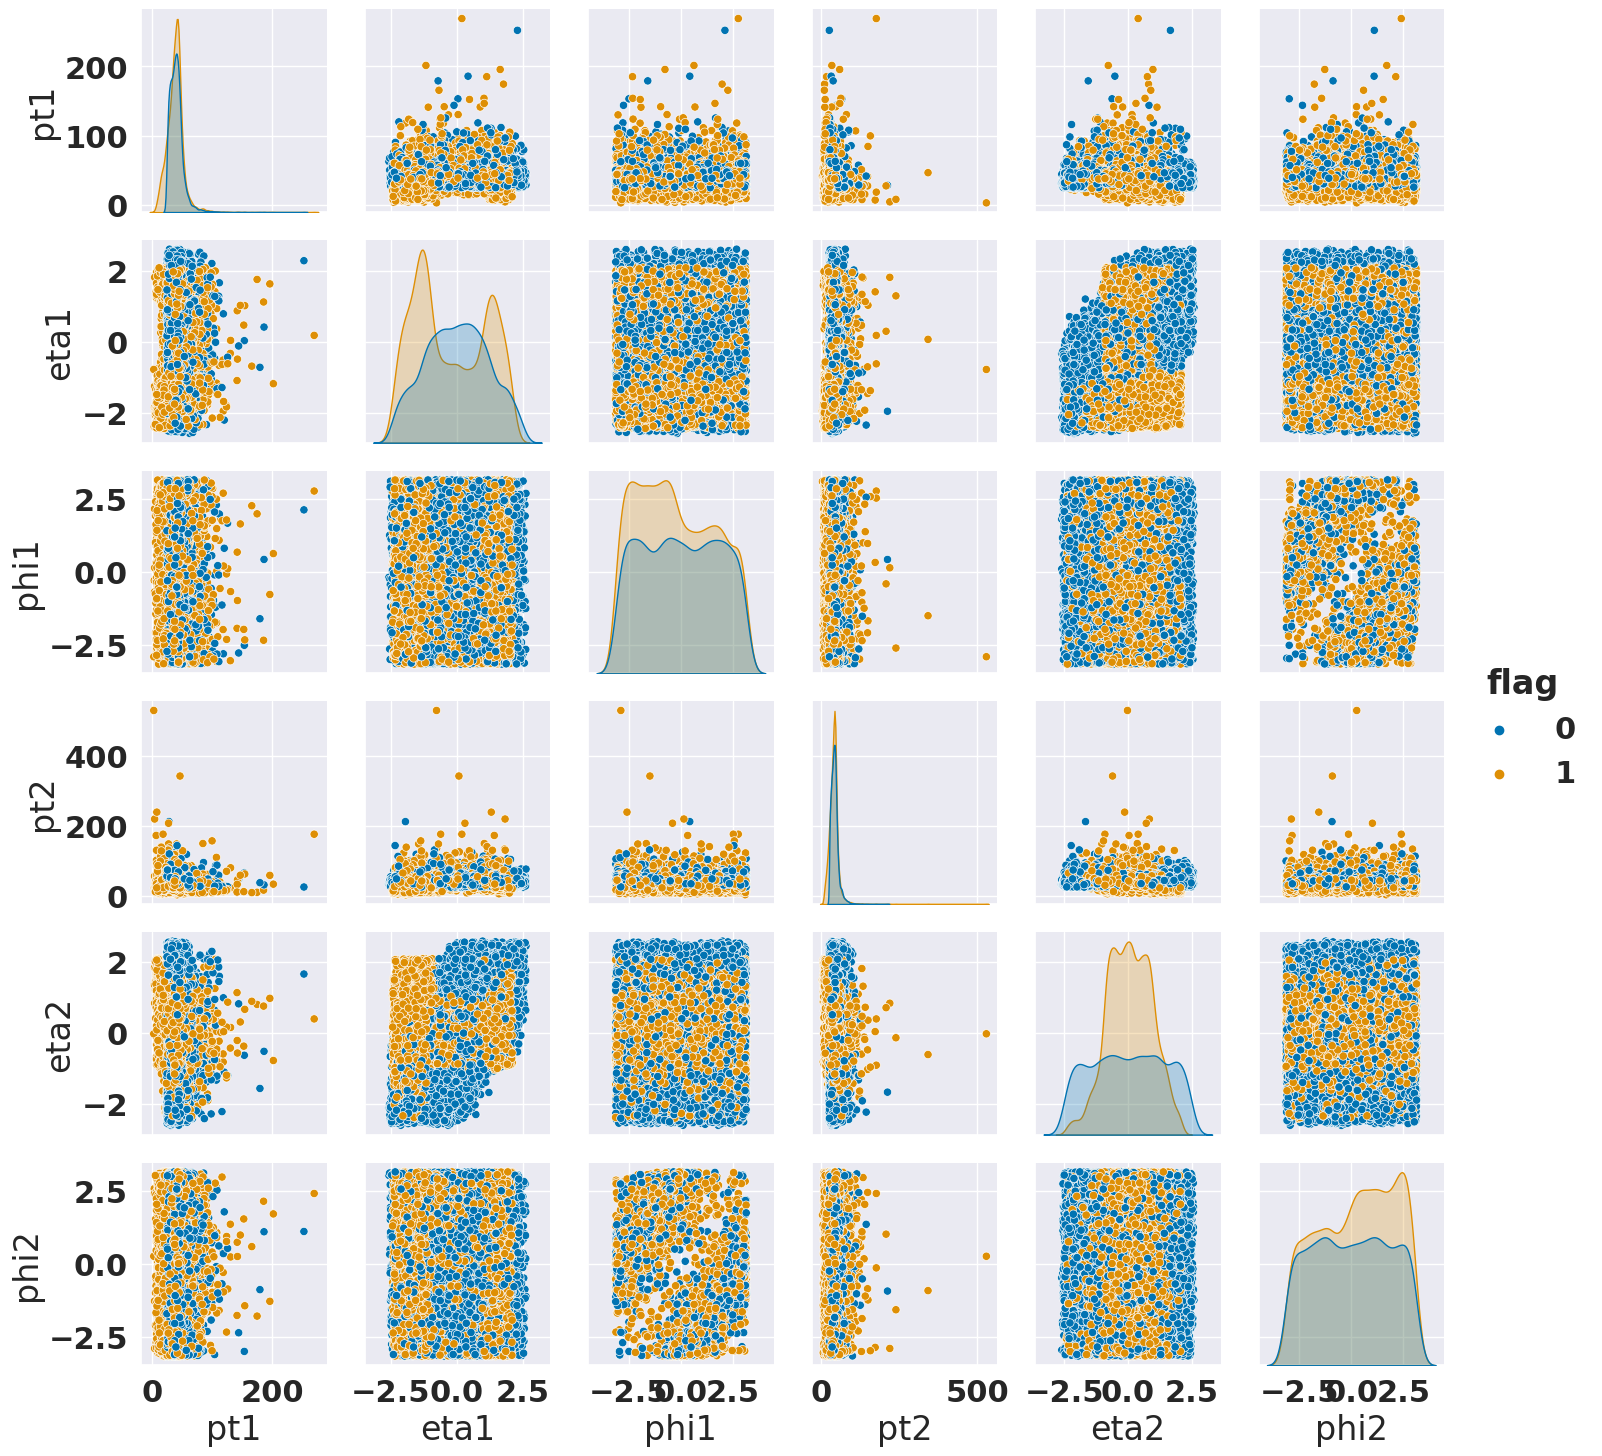

In [ ]:
df_reduced = df_all[['pt1', 'eta1', 'phi1', 'pt2', 'eta2', 'phi2', 'flag']]
plt.figure(figsize=(20, 15))
sns.set(font_scale=2.0)

#commenting this because it is slow
sns.pairplot(df_reduced, hue="flag", palette="colorblind")

## Wisker/box plots
Looking for outliers which could affect ML models

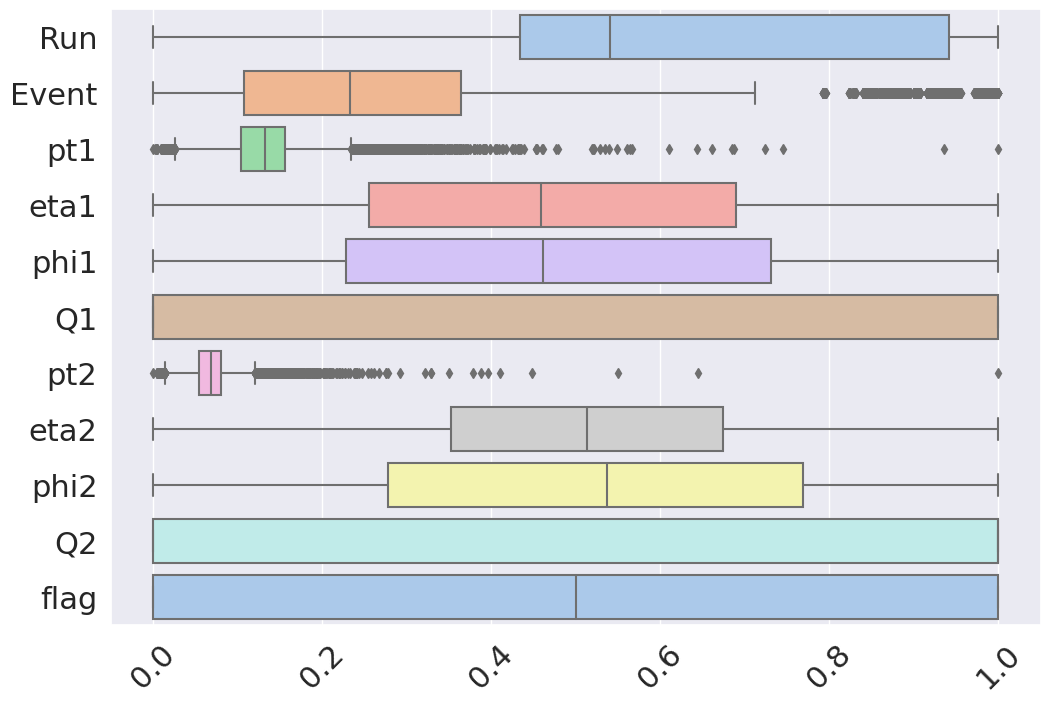

In [ ]:
#need to normalise data first to allow better visualisation of the plots
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_all)

plt.figure(figsize=(12, 8))
myplot = sns.boxplot(data=df_scaled, orient='h', palette='pastel')
plt.xticks(rotation=45)
myplot.set_yticklabels(df_all.columns)

plt.show()

While the Event number is not relevant, pt1 and pt2 may need some adjustments since they present outliers. I could take a modified version of the two features.

## Correlation matrix

<Axes: >

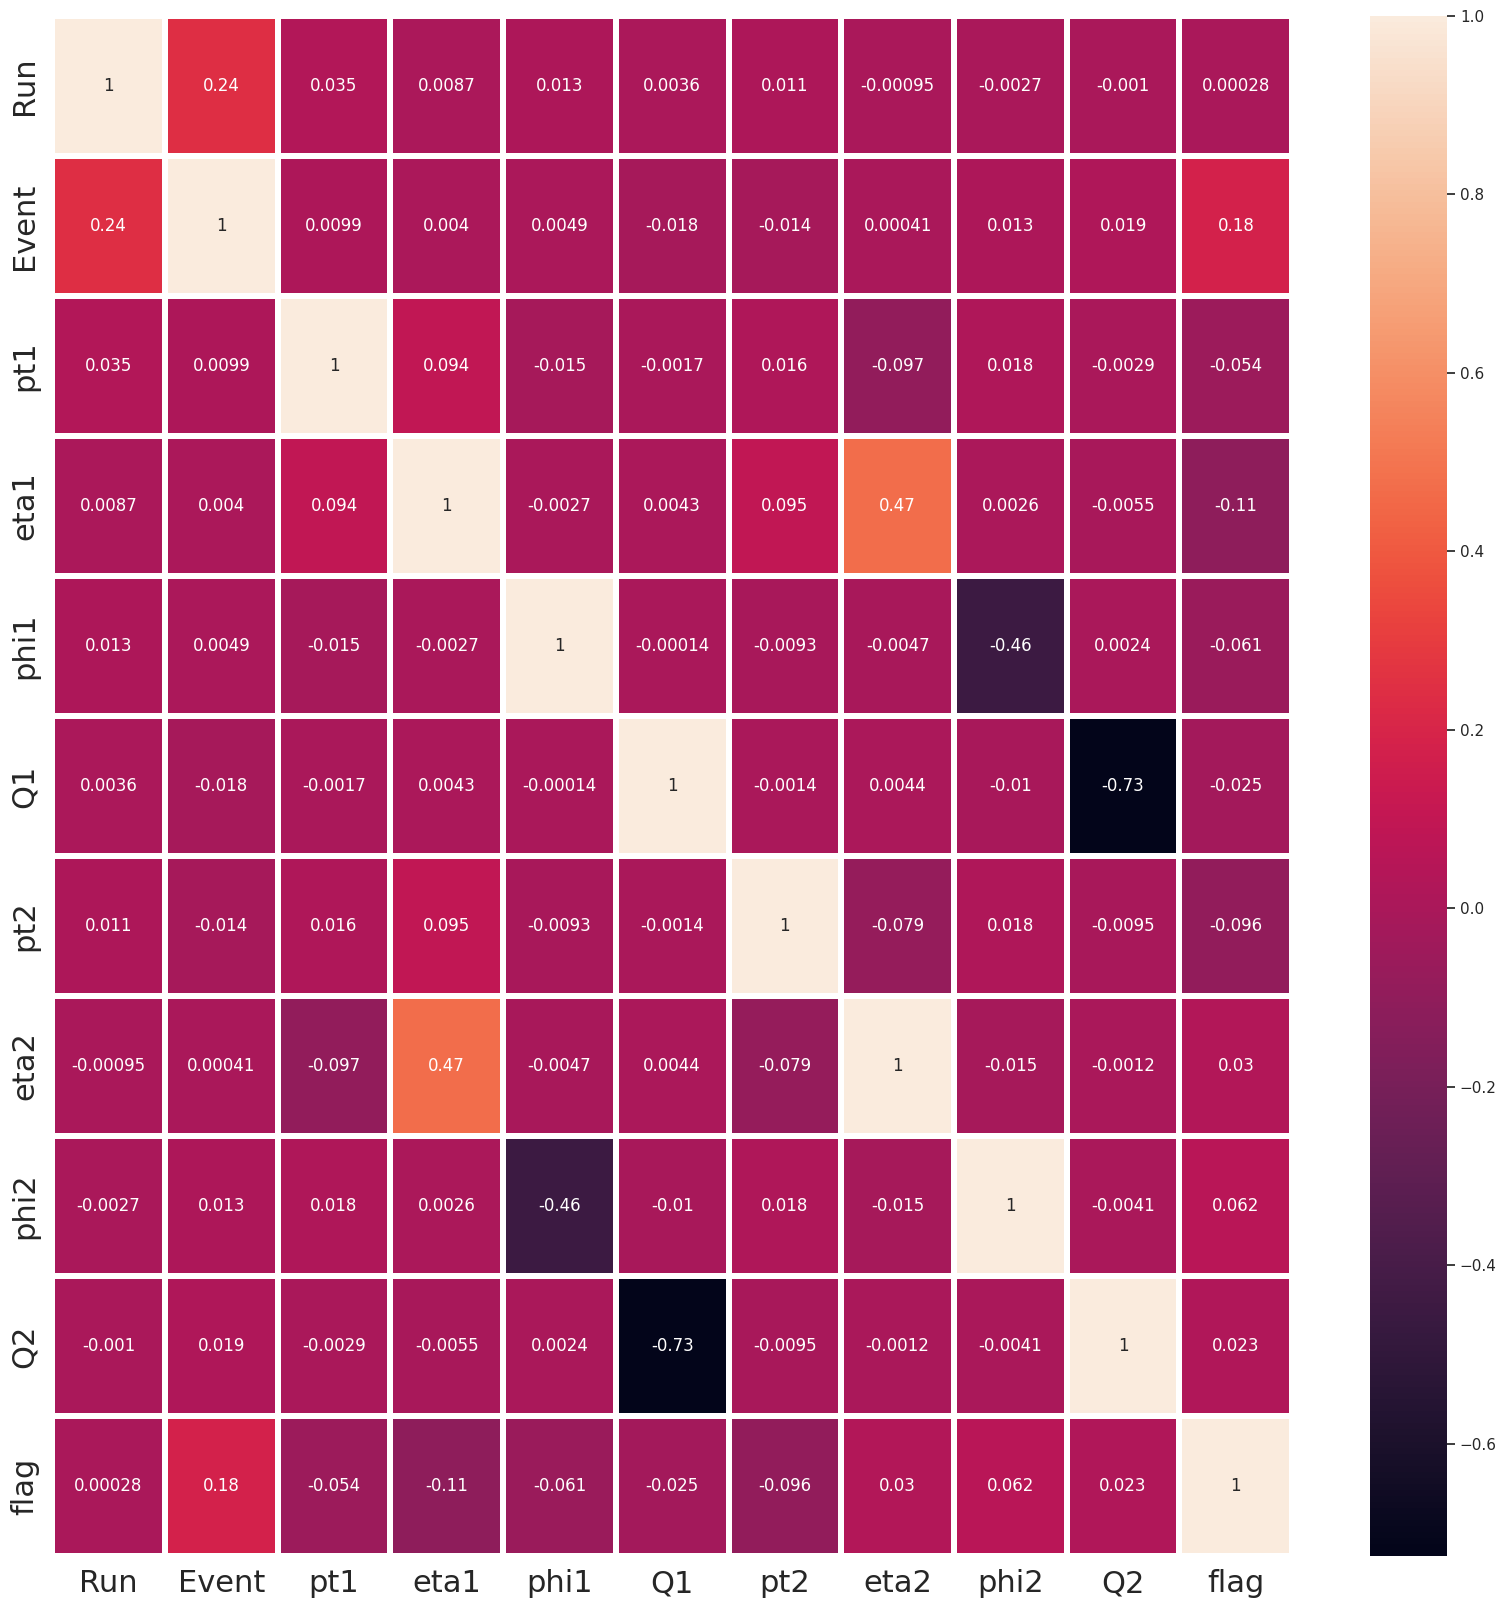

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
sns.set(font_scale=1.0)
sns.heatmap(df_all.corr() , annot= True, linewidths=3, ax=ax)

I expected Q1 and Q2 to be fully correlated, I am not looking for some exotic states which violate lepton number conservation, so let's see

In [ ]:
result = df_all[df_all['Q1'] == df_all['Q2']]
print(result)

          Run      Event      pt1    eta1    phi1  Q1      pt2    eta2  \
2      165570  196860468  72.9296 -0.4162  0.9198   1  39.5410 -0.2680   
10     166923  170807549  27.2940 -0.9795  2.4967  -1  38.4666  1.4119   
15     173389  507826220  26.3442 -0.7540  2.5005   1  77.8884 -1.6280   
18     163817  610616843  28.3804  1.9148 -1.4398   1  39.5451  2.1072   
23     173692  371458626  10.7333 -1.9365 -0.2734   1  17.1353  1.0434   
...       ...        ...      ...     ...     ...  ..      ...     ...   
19982  167098  252050147  41.5732 -0.0262 -2.4226   1  44.1128 -0.5530   
19985  163385   44534260  27.6265  1.1821  0.9633  -1  41.2031  0.0127   
19986  172163  184430706  27.9485  0.6709  0.5526  -1  54.7299  1.7427   
19989  165548  629940741  27.5815  0.1068 -0.4819  -1  36.7229  0.0371   
19997  173389  687651225  35.2640 -2.2673 -0.3794  -1  37.2768 -1.8151   

         phi2  Q2  flag  
2     -1.4629   1     0  
10    -0.6945  -1     0  
15    -1.0916   1     0  
18     

There was no original requirement on the charges for the Cern Open Data dataset, so I will exclude events where the charges have the same sign

In [ ]:
df_all = df_all[df_all['Q1'] != df_all['Q2']]

<Axes: >

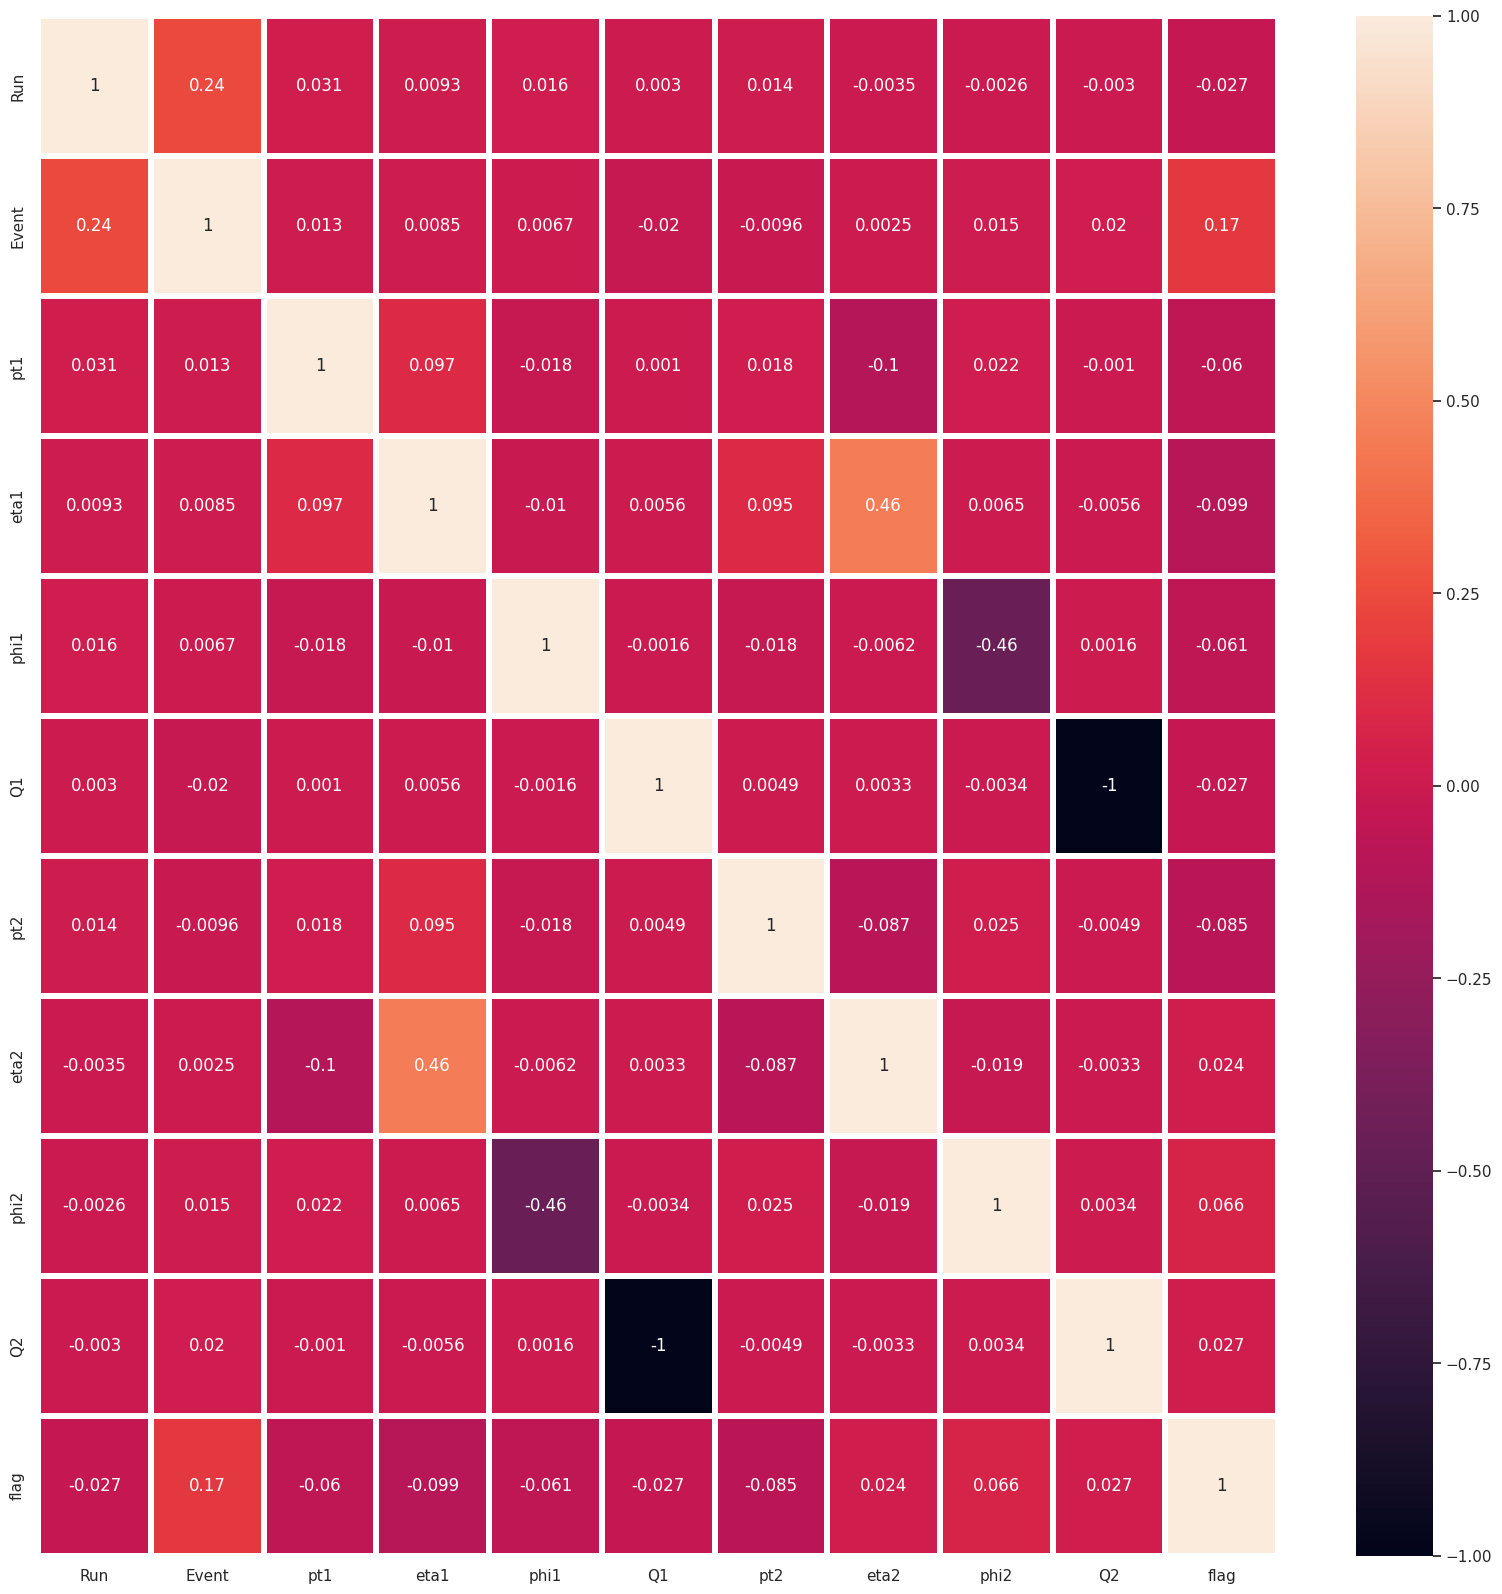

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
sns.set(font_scale=1.0)
sns.heatmap(df_all.corr() , annot= True, linewidths=3, ax=ax)

Even if the charges are fully anti-correlated I have decided to keep that feature

## Density plots
I am using Seaborn kernel density estimate (KDE) plots. Plotting individually the features of the df I want to use, for clear visualisation.

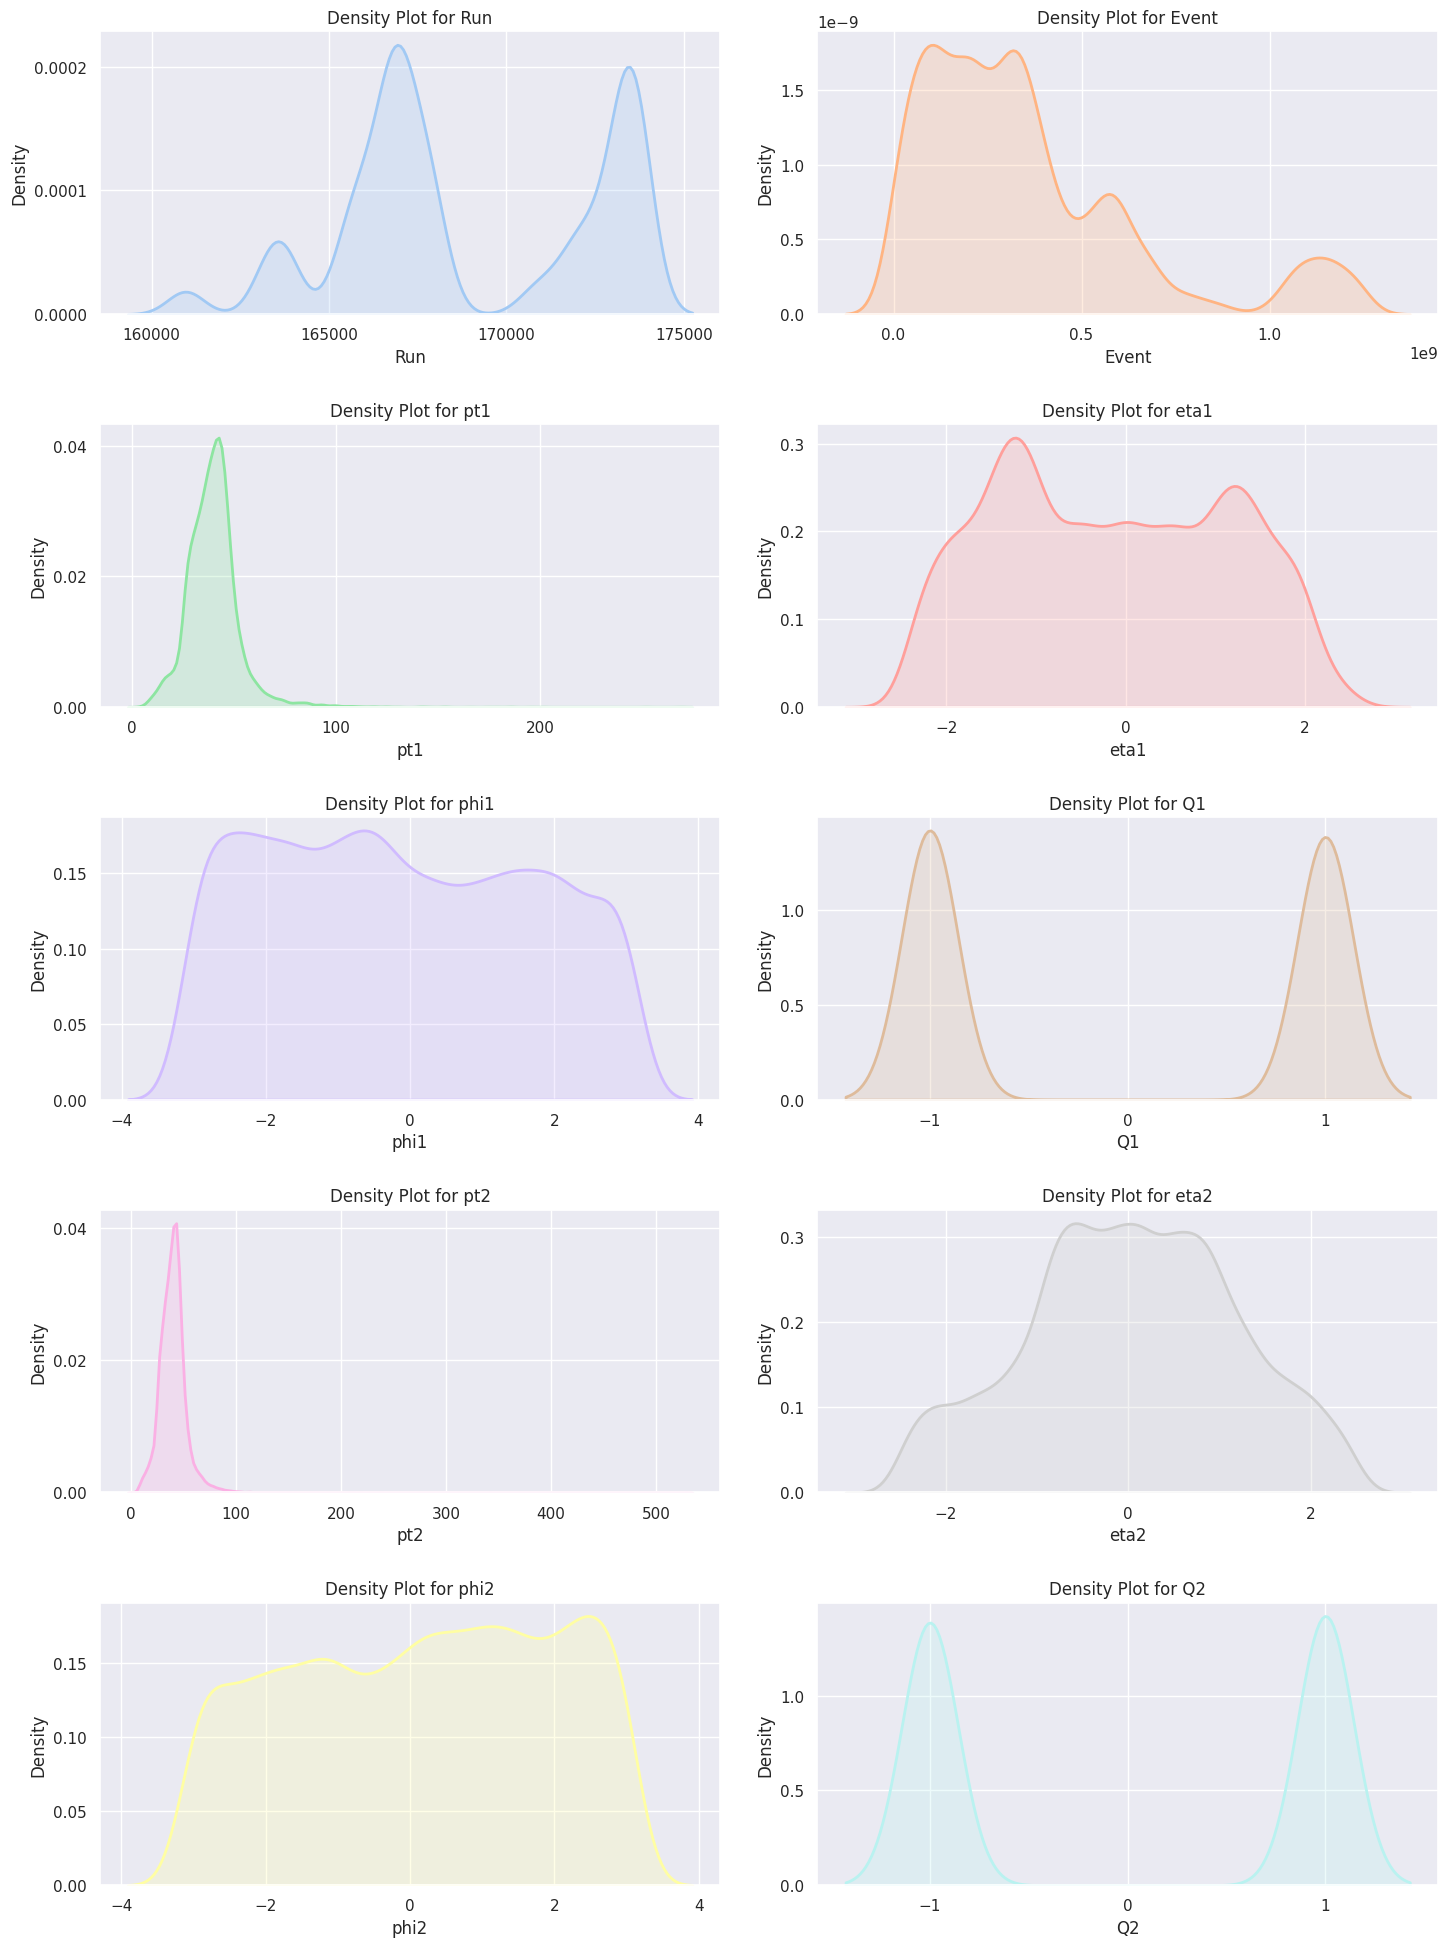

In [ ]:
fig, axes = plt.subplots(5, 2, figsize=(15, 20))
axes = axes.flatten()
columns_to_plot = [col for col in df_all.columns if col != 'flag']
sns.set_palette("pastel")
colors=sns.color_palette()
line_width = 2.0
for i, feature in enumerate(columns_to_plot):
    sns.kdeplot(data=df_all[feature], fill=True, ax=axes[i], color=colors[i],linewidth=line_width)
    axes[i].set_title(f'Density Plot for {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')
sns.set(font_scale=2.0)
plt.tight_layout()
plt.show()


# Features handling


##To sum up


*   DONE
  - I have taken all the common columns among the two datasets, joined and shuffled the datasets
  - I have looked at the data, checking for bad events
  - I have excluded events without opposite charge particles
* TO DO
  - I want to experiment on how to improve separation on pT
  

<Figure size 2000x1500 with 0 Axes>

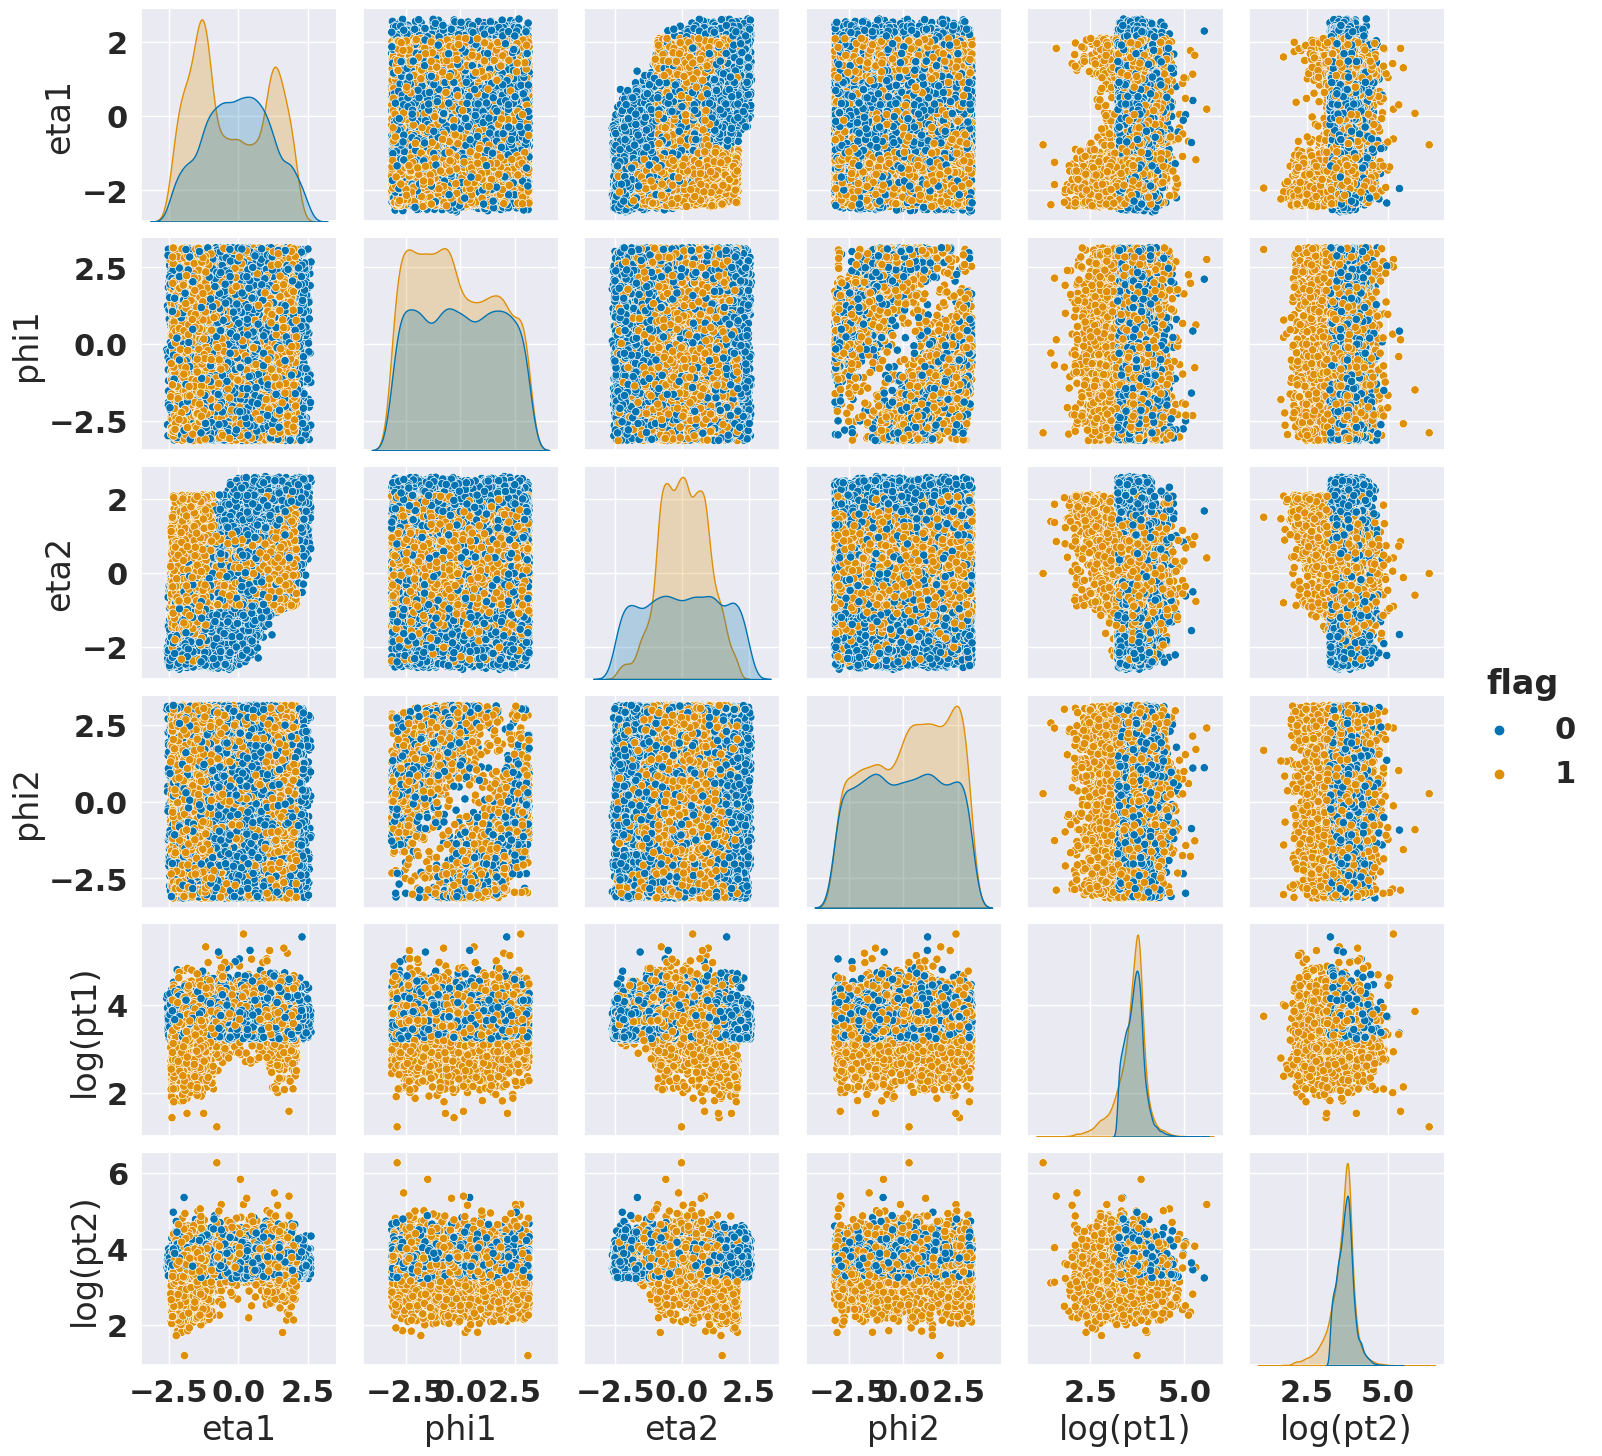

In [ ]:
#what if I take the log of pT, is it better?
df_all_mod = df_all.copy()
df_all_mod["log(pt1)"] = df_all_mod.pt1.apply(np.log)
df_all_mod["log(pt2)"] = df_all_mod.pt2.apply(np.log)
df_all_mod = df_all_mod.drop(['pt1', 'pt2'], axis=1)
#df_all.head()
df_reduced2 = df_all_mod[['eta1', 'phi1', 'eta2', 'phi2', 'flag', 'log(pt1)', 'log(pt2)']]
plt.figure(figsize=(20, 15))
sns.set(font_scale=2.0)

#commenting this because it is slow
sns.pairplot(df_reduced2, hue="flag", palette="colorblind")

Separation looks better

<Axes: >

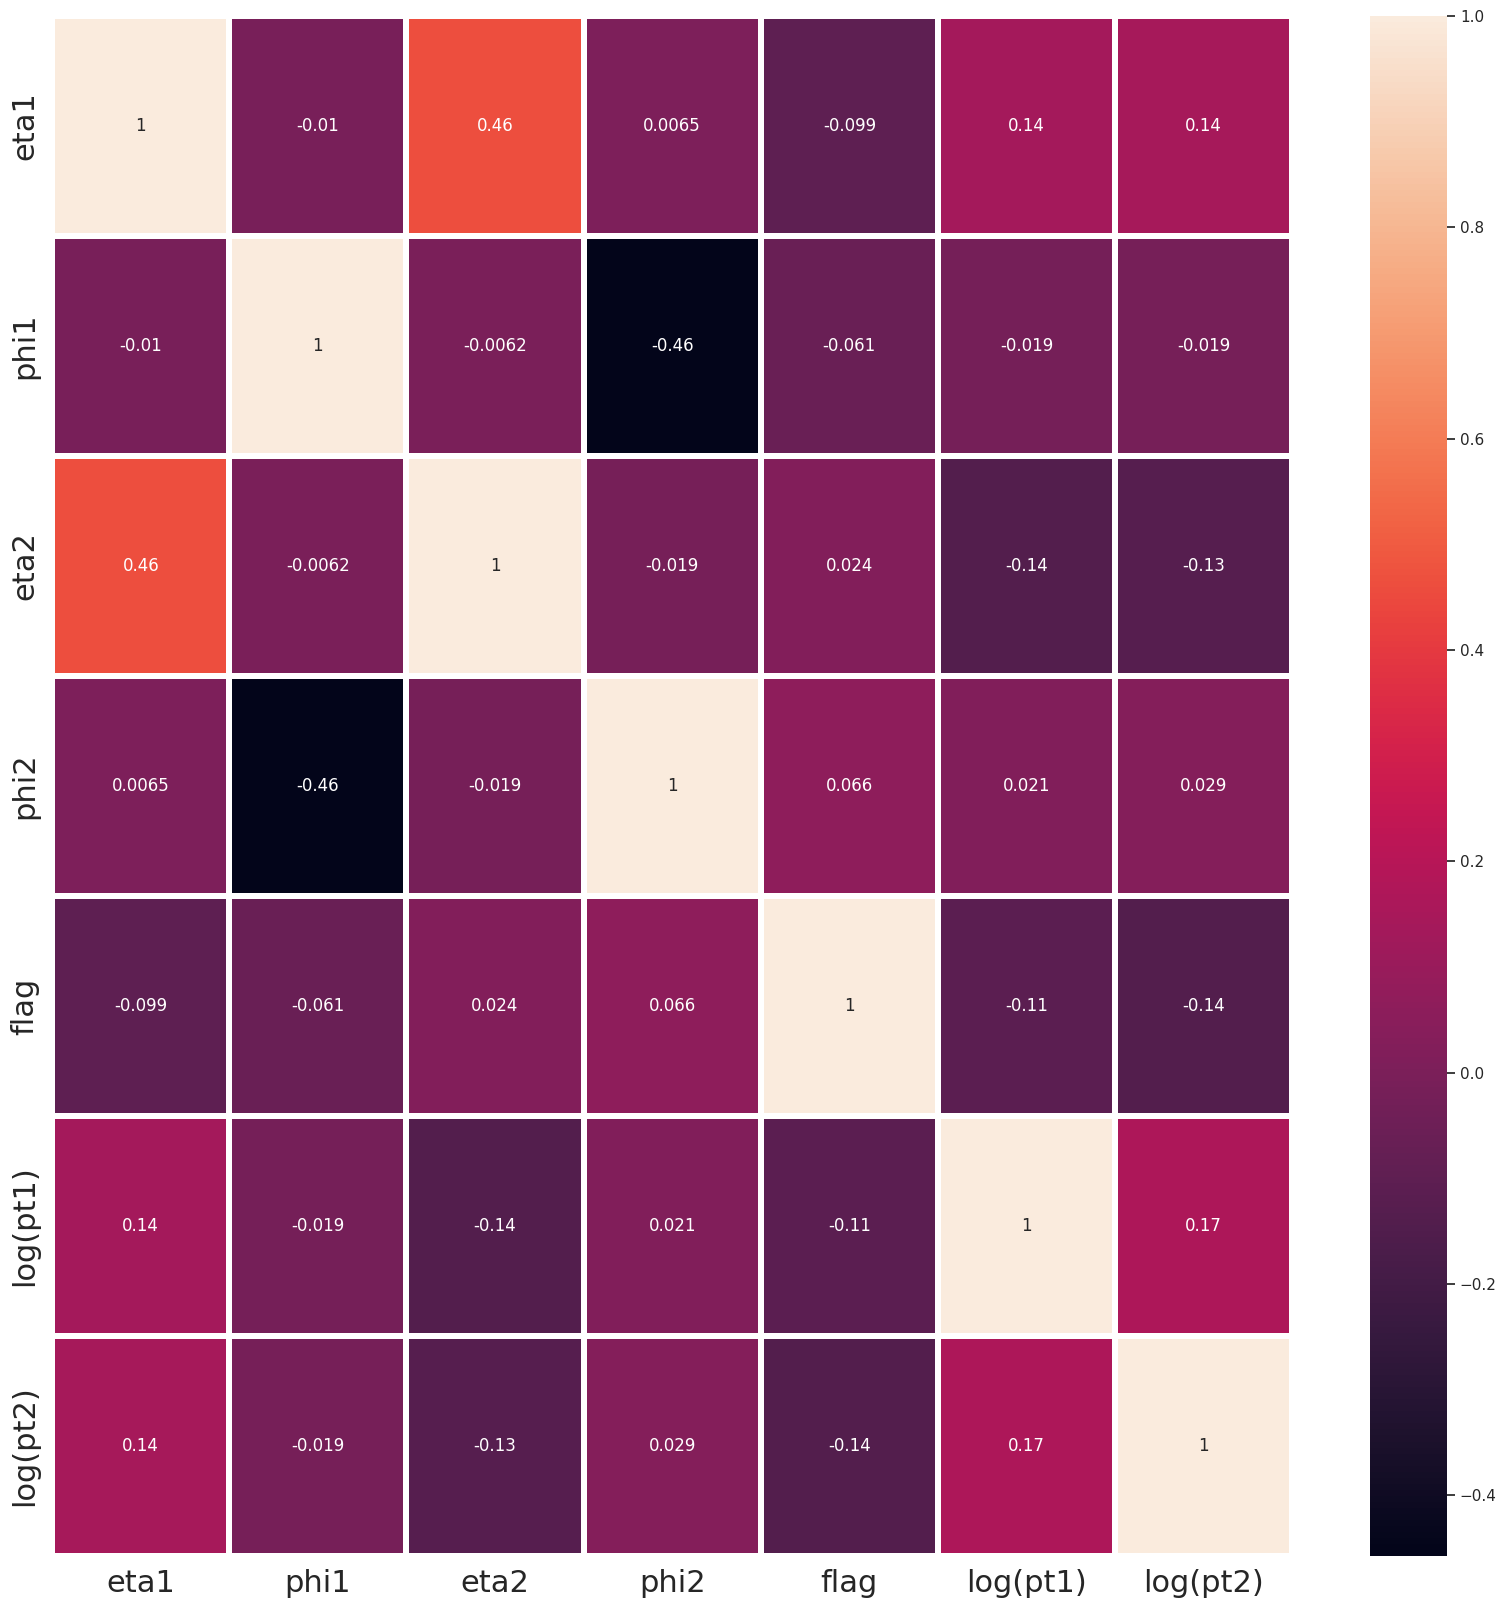

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
sns.set(font_scale=1.0)
sns.heatmap(df_reduced2.corr(), annot= True, linewidths=3, ax=ax)

# Ready for Machine Learning

Let's prepare the data for ML. I am using the dataframe with the log of the pt (df_all_mod)

First I split the data in train and test sets.

In [ ]:
print(df_all_mod.columns)
df_final = df_all_mod[['Run', 'Event', 'eta1', 'phi1', 'Q1', 'eta2', 'phi2', 'Q2', 'flag', 'log(pt1)', 'log(pt2)']]

X = df_final.drop(['flag'], axis=1)
y = df_final['flag']
print(f"X shape: {X.shape}")
print(list(X.columns))
print(X)
print(f"y shape: {y.shape}")
print(y.head())

train_to_test_ratio = 0.8
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=train_to_test_ratio,
    test_size=1-train_to_test_ratio,
    random_state=42)

#normalisation

scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Index(['Run', 'Event', 'eta1', 'phi1', 'Q1', 'eta2', 'phi2', 'Q2', 'flag',
       'log(pt1)', 'log(pt2)'],
      dtype='object')
X shape: (17255, 10)
['Run', 'Event', 'eta1', 'phi1', 'Q1', 'eta2', 'phi2', 'Q2', 'log(pt1)', 'log(pt2)']
          Run      Event    eta1    phi1  Q1    eta2    phi2  Q2  log(pt1)  \
0      166784   20257329 -1.3248 -3.0057  -1 -0.6624  0.3485   1  3.759175   
1      163261   64679856 -0.0057 -0.7744  -1  1.3710  2.2952   1  3.685735   
3      172163  497791581  0.3063 -1.6034   1 -1.6182  1.5315  -1  3.509860   
4      173692  550966077  0.4276 -0.3876  -1 -0.3080  2.8965   1  3.783794   
5      166033  486574461  1.2482  2.7103  -1  1.0228 -0.4599   1  3.881883   
...       ...        ...     ...     ...  ..     ...     ...  ..       ...   
19994  167098  195901717  1.0541 -2.3272   1  1.8076  0.8776  -1  4.147885   
19995  163589   25170371  0.0434  2.8371  -1 -0.8716 -0.7647   1  3.667625   
19996  166033  486199311 -1.3922 -1.9531  -1 -0.9045  0.8390   

We can start with testing some common classifiers.
One based on deicision trees, one on neighbours and one linear

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

def plot_prc(myinstance, split):
  probs = myinstance.predict_proba(X.iloc[split])[:, 1]
  prec, recall, thres = precision_recall_curve(y.iloc[split], probs)
  myinstance_text = f"{myinstance}"
  clf_name = myinstance_text.partition("(")[0]
  print("\n\n ==>", clf_name)
  print(f" ======> AUPRC: {auc(recall, prec):0.4f}")
  fig = plt.figure(figsize=(10, 6))
  plt.plot(recall, prec)
  plt.plot([1, 0], [0, 1])
  plt.xlim(0, 1.001)
  plt.ylim(0, 1.001)
  plt.ylabel("Precision")
  plt.xlabel("Recall")
  plt.show()

In [ ]:
clf_dict = {
    RandomForestClassifier: dict(min_samples_split=10, n_estimators=10, warm_start=True, verbose=1),
    KNeighborsClassifier: dict(n_neighbors = 10),
    LogisticRegression: dict(random_state=42),
 }

results = []
names = []
allInstances = []

kfold = KFold(n_splits=20, random_state=42, shuffle=True)
split_index = [(train_index, test_index) for train_index, test_index in kfold.split(X) ]
id_estim = 17

for clf in clf_dict:

  instance = clf(**clf_dict[clf])

  clf_name = clf.__name__
  names.append(clf_name)

  cv_results = cross_validate(instance, X, y, cv=kfold, scoring='accuracy', return_estimator=True)

  results.append(cv_results["test_score"])
  allInstances.append(cv_results['estimator'][id_estim])

Let's see the boxplot


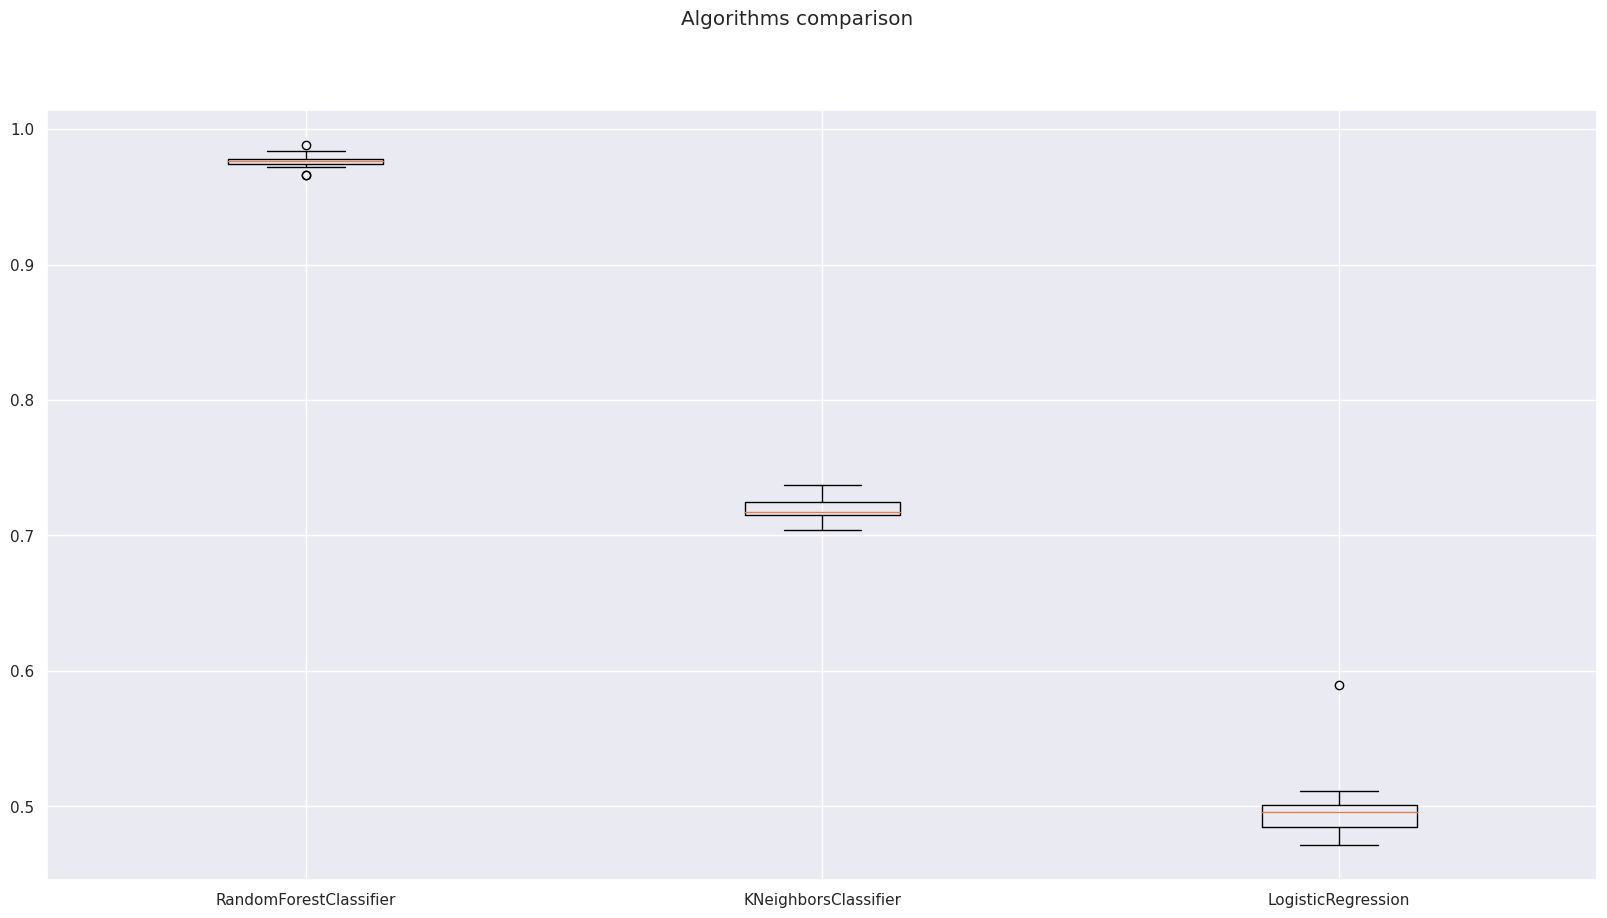

In [ ]:
from matplotlib import pyplot
fig = pyplot.figure(figsize=(20, 10))
fig.suptitle('Algorithms comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

I want to plot a random fold to see what the precision recall curves look like



 ==> RandomForestClassifier
 ======> AUPRC: 0.9963


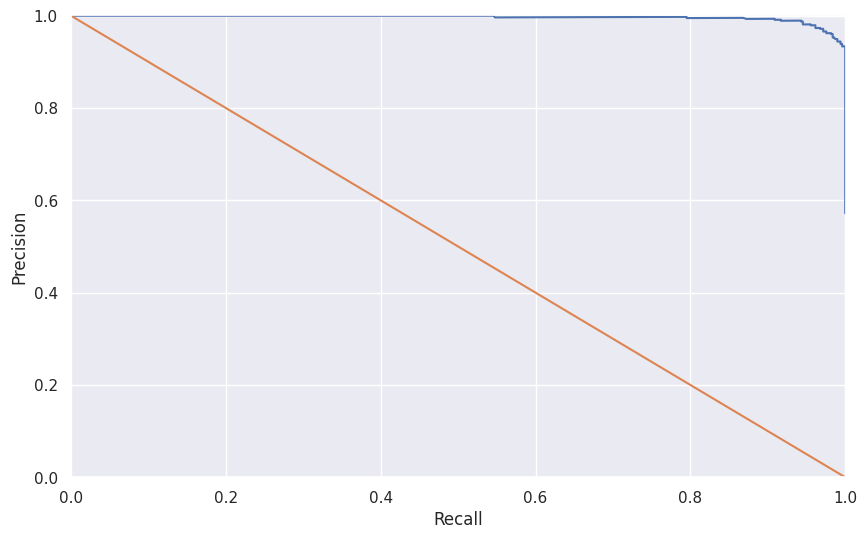



 ==> KNeighborsClassifier
 ======> AUPRC: 0.8692


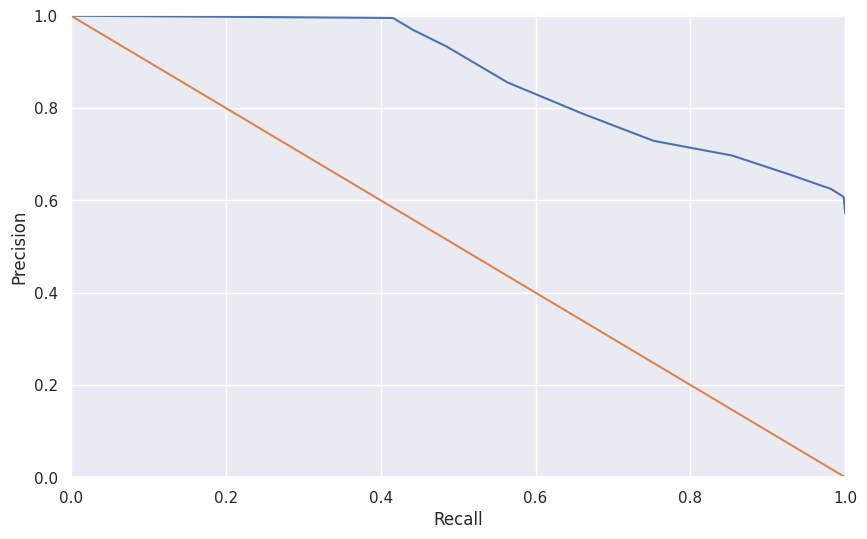



 ==> LogisticRegression
 ======> AUPRC: 0.6695


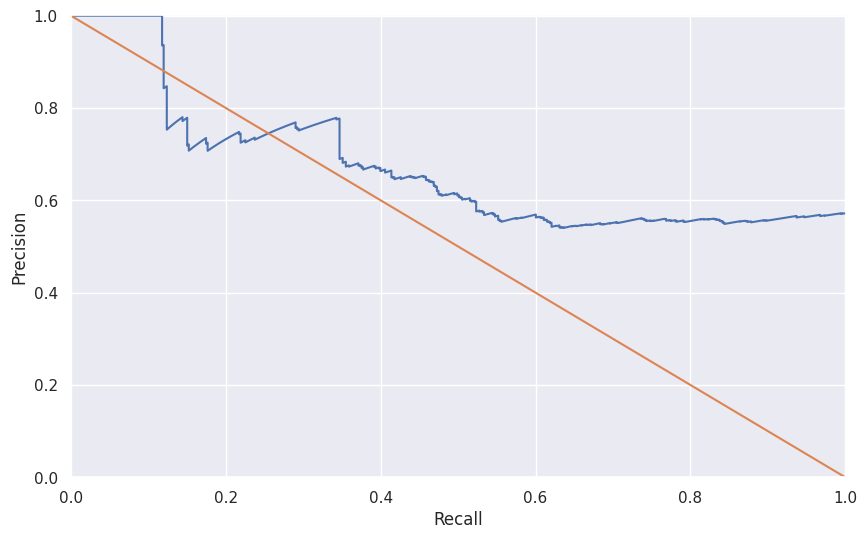

In [ ]:
for inst in allInstances:
  plot_prc(inst, split_index[id_estim][1])

# Improving the classifiers hyperparameters

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import HistGradientBoostingClassifier

#I may want to look at the learning curves for better optimisation so I define a function to plot them
def plot_learning_curve(estimator, title, X, y, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 20)):
    plt.figure(figsize=(10, 6))
    plt.title(title, fontsize=18)
    plt.xlabel("Training Examples", fontsize=14)
    plt.ylabel("Score", fontsize=14)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="blue")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#E76B0B")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="blue",
             label="Training Score", markersize=5)
    plt.plot(train_sizes, test_scores_mean, 'o-', color="#E76B0B",
             label="Cross-Validation Score", markersize=5)

    plt.legend(loc="best", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)

    return plt



### KNeighborsClassifier
This classifier is performing not so great, I try a grid search to tune its hyperparameters

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


param_grid = {
    'n_neighbors': [8, 10, 11, 12, 13, 14, 16],
    'weights': ['uniform', 'distance'],  # Weighting scheme
    'p': [1, 2]  # Power parameter for Minkowski distance (1 for Manhattan, 2 for Euclidean)
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
print("Best Hyperparameters:", best_parameters)
best_score = grid_search.best_score_
print("Best Accuracy Score:", best_score)

Best Hyperparameters: {'n_neighbors': 12, 'p': 1, 'weights': 'uniform'}
Best Accuracy Score: 0.8335258439233841


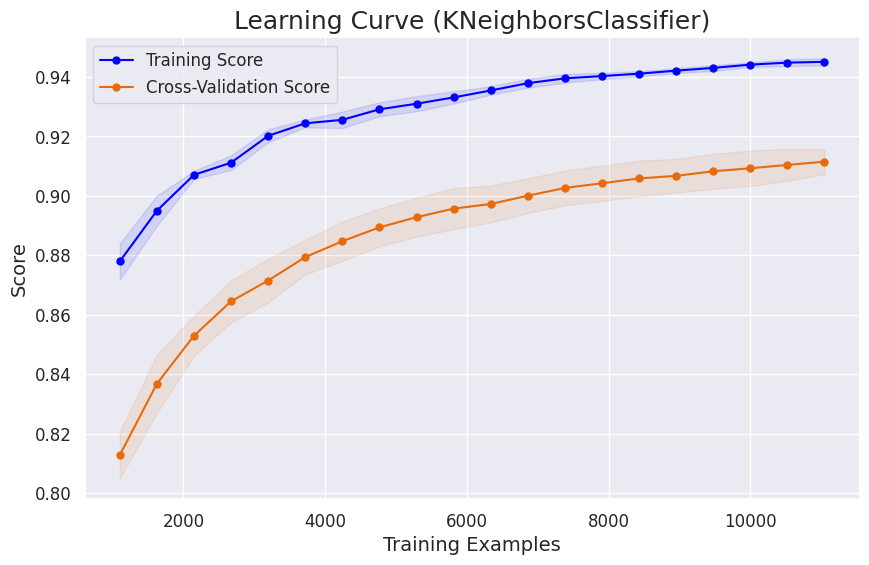

In [ ]:
best_params = {
    'n_neighbors': grid_search.best_params_['n_neighbors'],
    'weights': grid_search.best_params_['weights'],
    'p':  grid_search.best_params_['p'],
}
clf = KNeighborsClassifier(**best_params)
title = "Learning Curve (KNeighborsClassifier)"
plot_learning_curve(clf, title, X_train, y_train, cv=5,train_sizes=np.linspace(0.1, 1.0, 20))
plt.show()

I do not think this classifier is the optimal for my data given the nature of my dataset and the charactersitics of the classifier (dataset is small but there is no particular pattern in which distance could be useful to measure similarity among data points)
Increasing the trainig size does not appear to be productive since the curves run parallel to eachother

### LogisticRegression

I want to try a Randomized search CV which can be convenient given the small dataset I have

Best Hyperparameters:  {'warm_start': False, 'solver': 'liblinear', 'max_iter': 487, 'C': 0.46}
Best Score:  0.580628363295359
 ======> AUPRC: 0.7363


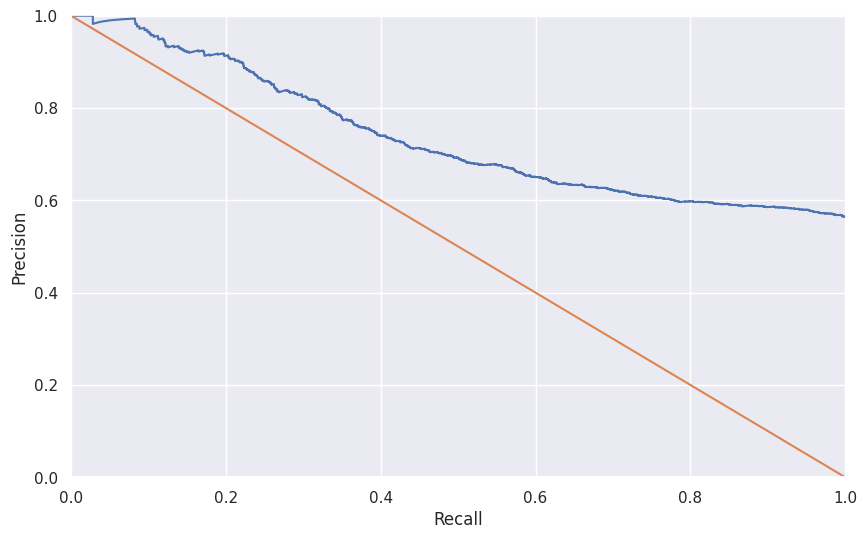

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'C': np.arange(0, 1, 0.01),
    'max_iter': range(100, 500),
    'solver': ['lbfgs', 'newton-cg', 'liblinear'],
    'warm_start': [True, False]
}


random_search = RandomizedSearchCV(LogisticRegression(), param_distributions=param_dist, n_iter=20, cv=3, scoring='accuracy', random_state=42)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Hyperparameters: ", best_params)
print("Best Score: ", best_score)

best_model = random_search.best_estimator_

probs = best_model.predict_proba(X_test)[:, 1]
prec, recall, thres = precision_recall_curve(y_test, probs)
print(f" ======> AUPRC: {auc(recall, prec):0.4f}")
fig = plt.figure(figsize=(10, 6))
plt.plot(recall, prec)
plt.plot([1, 0], [0, 1])
plt.xlim(0, 1.001)
plt.ylim(0, 1.001)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

A logistic regression, given the distribution of my features, is not an optimal choice

### RandomForestClassifier



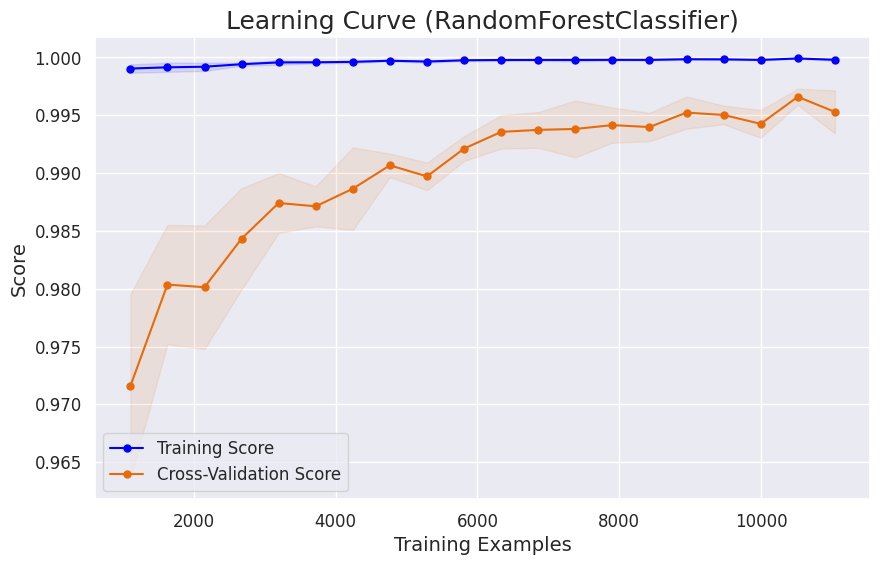

In [ ]:
clf = RandomForestClassifier(min_samples_split=10, n_estimators=10, warm_start=True, verbose=1)
title = "Learning Curve (RandomForestClassifier)"
plot_learning_curve(clf, title, X_train, y_train, cv=5)
plt.show()

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 93, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
Best Score: 0.9787740686974088
 ======> AUPRC: 0.9993


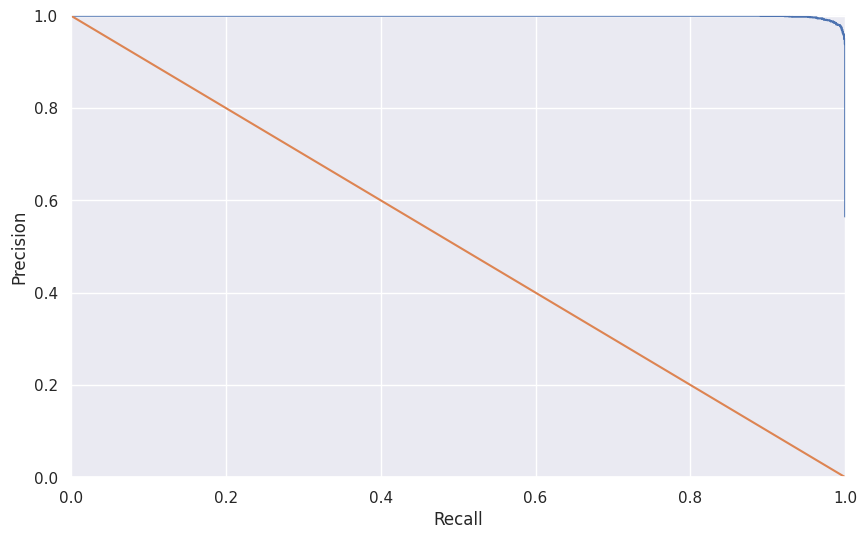

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start = 40, stop = 120, num = 10)],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [5,10,20,30,40],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}


random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_dist, n_iter=20, cv=3, scoring='accuracy', random_state=42, verbose=1, n_jobs=-1)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

best_model = random_search.best_estimator_

probs = best_model.predict_proba(X_test)[:, 1]
prec, recall, thres = precision_recall_curve(y_test, probs)
print(f" ======> AUPRC: {auc(recall, prec):0.4f}")
fig = plt.figure(figsize=(10, 6))
plt.plot(recall, prec)
plt.plot([1, 0], [0, 1])
plt.xlim(0, 1.001)
plt.ylim(0, 1.001)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.show()

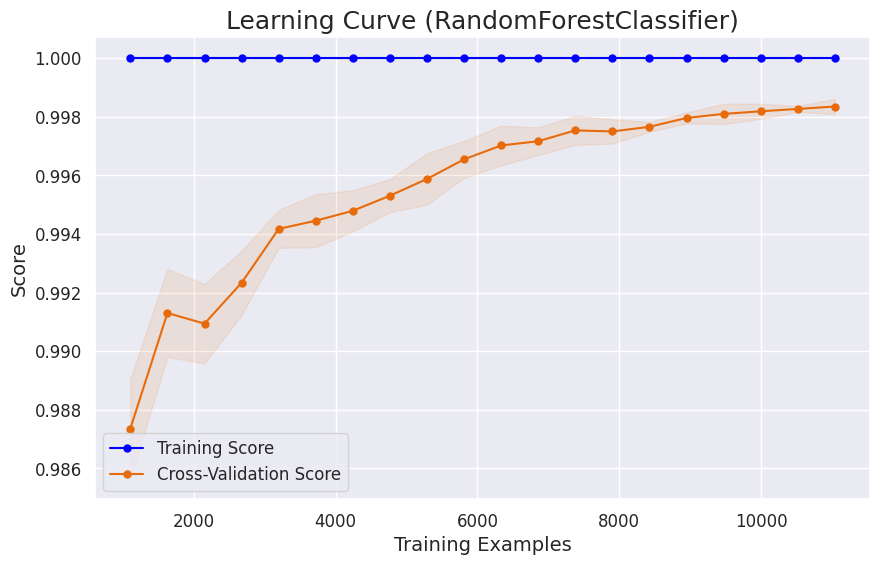

In [ ]:
title = "Learning Curve (RandomForestClassifier)"
plot_learning_curve(best_model, title, X_train, y_train)
plt.show()

In the end I think that we can achieve the best performance with the Random Foresta classifiera, given the characteristics of the dataset.
I believe I can say that we are still avoiding overfitting because even if the training score is basically always at 1, on the CV we see improvements for different training sizes.

# Implementation of a NN

Let's see how we can implement a small NN to work on this dataset




In [ ]:
#I define function for plotting, useful for my NN models
def make_prcurve(model):
  y_pred = model.predict(X_test)
  precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
  average_precision = average_precision_score(y_test, y_pred)
  plt.figure(figsize=(10, 6))
  plt.plot(recall, precision, marker='.')
  plt.plot([1, 0], [0, 1])
  plt.xlim(0, 1.001)
  plt.ylim(0, 1.001)
  plt.ylabel('Precision')
  plt.xlabel('Recall')
  plt.title(f'Average PRC={average_precision:.3f}')
  plt.grid(True)
  plt.show()

In [ ]:
import tensorflow as tf
from sklearn.metrics import average_precision_score

def my_NN():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu',),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

model = my_NN()
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
432/432 [==============================] - 5s 5ms/step - loss: 0.6538 - accuracy: 0.5971 - val_loss: 0.6228 - val_accuracy: 0.6363
Epoch 2/20
432/432 [==============================] - 2s 5ms/step - loss: 0.5958 - accuracy: 0.6686 - val_loss: 0.5626 - val_accuracy: 0.7082
Epoch 3/20
432/432 [==============================] - 2s 5ms/step - loss: 0.5314 - accuracy: 0.7317 - val_loss: 0.5062 - val_accuracy: 0.7465
Epoch 4/20
432/432 [==============================] - 2s 4ms/step - loss: 0.4993 - accuracy: 0.7558 - val_loss: 0.4871 - val_accuracy: 0.7644
Epoch 5/20
432/432 [==============================] - 2s 4ms/step - loss: 0.4841 - accuracy: 0.7659 - val_loss: 0.4952 - val_accuracy: 0.7389
Epoch 6/20
432/432 [==============================] - 2s 4ms/step - loss: 0.4744 - accuracy: 0.7724 - val_loss: 0.4719 - val_accuracy: 0.7691
Epoch 7/20
432/432 [==============================] - 2s 4ms/step - loss: 0.4647 - accuracy: 0.7814 - val_loss: 0.4676 - val_accuracy: 0.7754
Epoch 

108/108 [==============================] - 0s 2ms/step


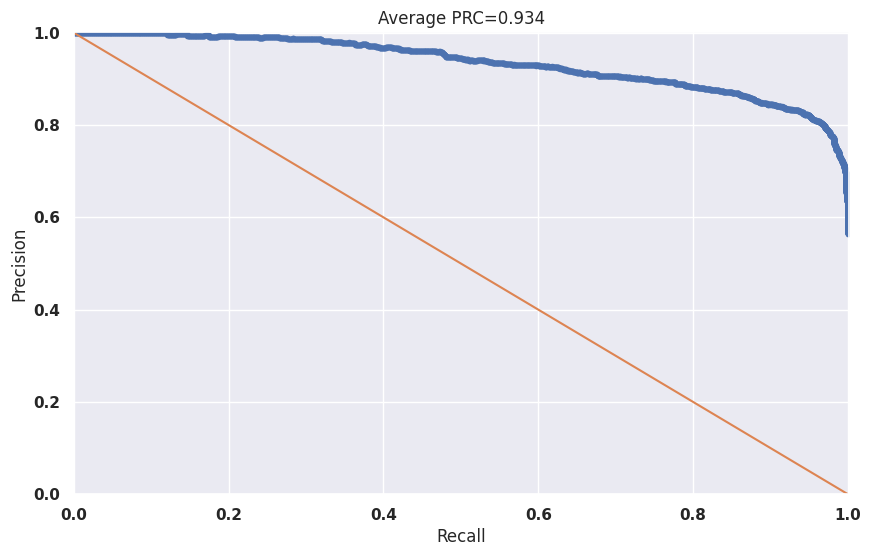

In [ ]:
make_prcurve(model)

108/108 - 0s - loss: 0.3443 - accuracy: 0.8470 - 251ms/epoch - 2ms/step


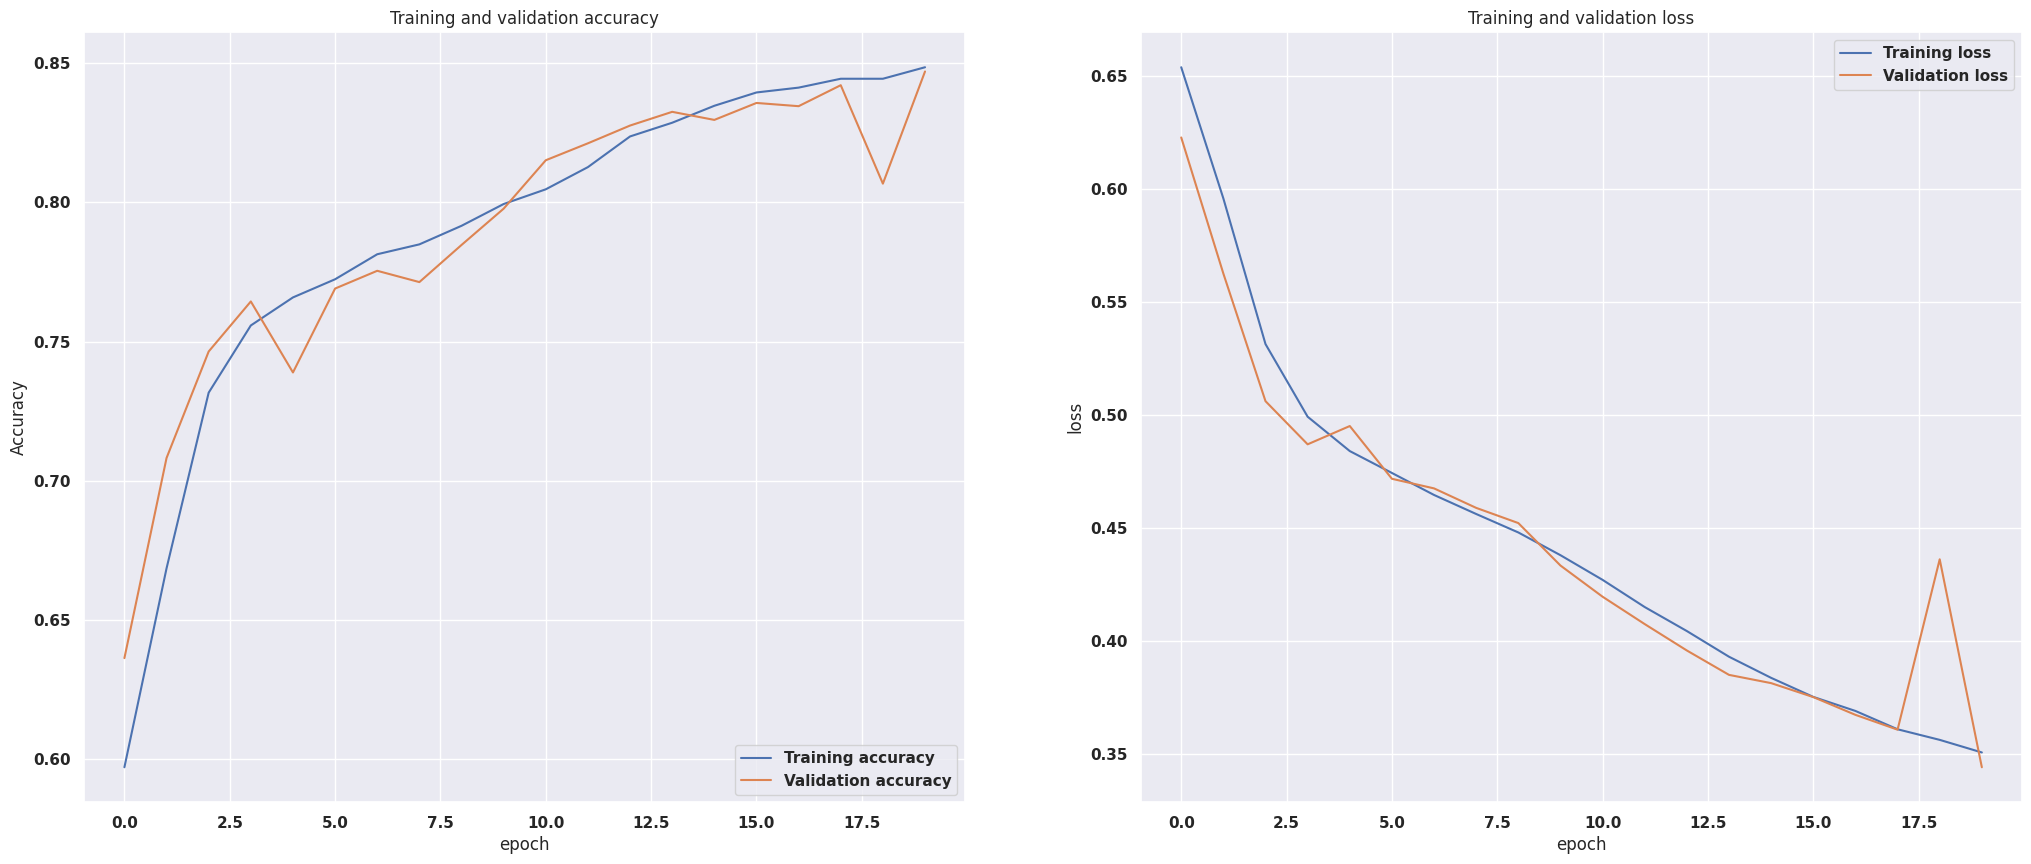

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)

plt.figure(figsize=(25,10))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.plot(history.history['accuracy'], label='Training accuracy')
ax1.plot(history.history['val_accuracy'], label = 'Validation accuracy')
ax1.set_title("Training and validation accuracy")
ax1.set(xlabel='epoch', ylabel='Accuracy')
ax1.legend(loc='lower right')

ax2.plot(history.history['loss'], label='Training loss')
ax2.plot(history.history['val_loss'], label='Validation loss')
ax2.set_title("Training and validation loss")
ax2.set(xlabel='epoch', ylabel='loss')
ax2.legend(loc='upper right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

## Improving my NN

It is performing already quite well (problme I have is not so complex, small dataset) but let's try to change the model to make it perform better.


In [ ]:
#need this to have KerasClassifier
pip install scikeras

In [ ]:
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ProgbarLogger
from tensorflow.keras.metrics import AUC
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from scikeras.wrappers import KerasClassifier


def my_NN(activation='relu', neurons1=128, neurons2=64):
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(neurons1, input_dim=X_train.shape[1], activation=activation),
      tf.keras.layers.Dense(neurons2, activation=activation),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', AUC(name='auc', curve='PR')])
  return model

In [ ]:
mymodel = KerasClassifier(model=my_NN)

param_grid = {
    'model__activation': ['relu', 'elu'],
    'model__neurons1': [64, 128],
    'model__neurons2': [32, 64]
}

grid_search = GridSearchCV(estimator=mymodel, param_grid=param_grid, scoring='accuracy', cv=3, verbose=2, error_score='raise')
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
144/144 [==============================] - 0s 2ms/step
[CV] END model__activation=relu, model__neurons1=64, model__neurons2=32; total time=   3.1s
144/144 [==============================] - 0s 2ms/step
[CV] END model__activation=relu, model__neurons1=64, model__neurons2=32; total time=   3.0s
144/144 [==============================] - 0s 2ms/step
[CV] END model__activation=relu, model__neurons1=64, model__neurons2=32; total time=   7.3s
144/144 [==============================] - 0s 2ms/step
[CV] END model__activation=relu, model__neurons1=64, model__neurons2=64; total time=   3.8s
144/144 [==============================] - 0s 2ms/step
[CV] END model__activation=relu, model__neurons1=64, model__neurons2=64; total time=   4.1s
144/144 [==============================] - 0s 2ms/step
[CV] END model__activation=relu, model__neurons1=64, model__neurons2=64; total time=   4.0s
144/144 [==============================] - 0s 2ms/step
[CV

GridSearchCV(cv=3, error_score='raise',
             estimator=KerasClassifier(model=<function my_NN at 0x7df6faf068c0>),
             param_grid={'model__activation': ['relu', 'elu'],
                         'model__neurons1': [64, 128],
                         'model__neurons2': [32, 64]},
             scoring='accuracy', verbose=2)

In [ ]:
best_model = my_NN(
     grid_search.best_params_['model__activation'],
     grid_search.best_params_['model__neurons1'],
     grid_search.best_params_['model__neurons2'],
)

print("Best Hyperparameters:",  grid_search.best_params_)

Best Hyperparameters: {'model__activation': 'relu', 'model__neurons1': 128, 'model__neurons2': 64}


In [ ]:
#CALLBACKS
save_dir ='model_checkpoints'
model_name = 'model-auc{val_auc:0.4f}-epoch{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

model_checkpoint = ModelCheckpoint(filepath=filepath, save_best_only=True, monitor='val_auc', mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_auc', patience=10, min_delta=0.0005, restore_best_weights=True, verbose=1)
progress_bar = ProgbarLogger()
#callbacks = [model_checkpoint, progress_bar]
callbacks = [model_checkpoint, progress_bar, early_stopping]

#FITTING BEST MODEL
history = best_model.fit(X_train, y_train, batch_size=32, epochs=50,
                    validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/50
      0/Unknown - 3s 0s/sample - loss: 0.6330 - accuracy: 0.6270 - auc: 0.7417
Epoch 1: val_auc improved from -inf to 0.83211, saving model to model_checkpoints/model-auc0.8321-epoch001.h5
432/432 [==============================] - 4s 10ms/sample - loss: 0.6328 - accuracy: 0.6272 - auc: 0.7421 - val_loss: 0.5658 - val_accuracy: 0.7227 - val_auc: 0.8321
Epoch 2/50
  0/432 [..............................] - ETA: 0s - loss: 0.5885 - accuracy: 0.6771 - auc: 0.7940

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


  0/432 [..............................] - ETA: 0s - loss: 0.5302 - accuracy: 0.7310 - auc: 0.8402
Epoch 2: val_auc improved from 0.83211 to 0.86748, saving model to model_checkpoints/model-auc0.8675-epoch002.h5
432/432 [==============================] - 2s 6ms/sample - loss: 0.5297 - accuracy: 0.7310 - auc: 0.8403 - val_loss: 0.4872 - val_accuracy: 0.7670 - val_auc: 0.8675
Epoch 3/50
  0/432 [..............................] - ETA: 0s - loss: 0.4833 - accuracy: 0.7690 - auc: 0.8636
Epoch 3: val_auc improved from 0.86748 to 0.87409, saving model to model_checkpoints/model-auc0.8741-epoch003.h5
432/432 [==============================] - 3s 7ms/sample - loss: 0.4833 - accuracy: 0.7690 - auc: 0.8636 - val_loss: 0.4726 - val_accuracy: 0.7833 - val_auc: 0.8741
Epoch 4/50
  0/432 [..............................] - ETA: 0s - loss: 0.4621 - accuracy: 0.7817 - auc: 0.8749
Epoch 4: val_auc improved from 0.87409 to 0.88152, saving model to model_checkpoints/model-auc0.8815-epoch004.h5
432/432 [===

108/108 [==============================] - 0s 2ms/step


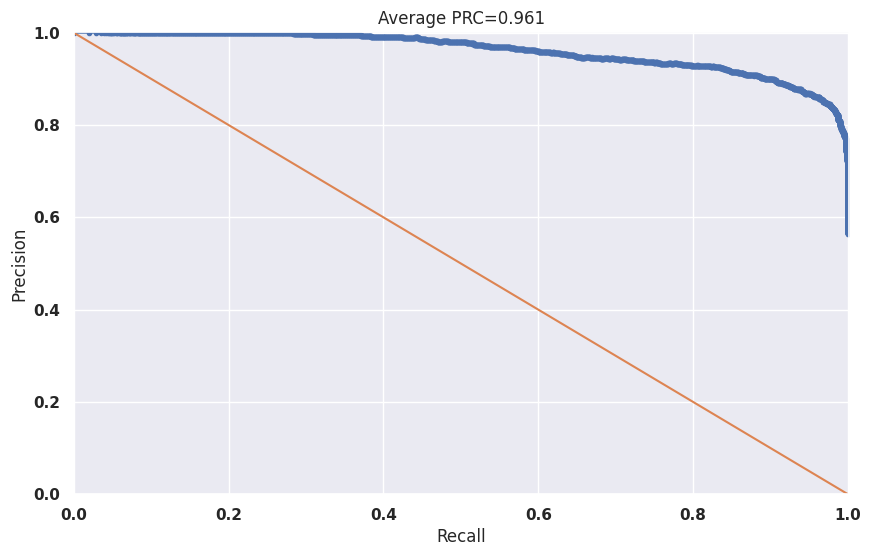

In [ ]:
make_prcurve(best_model)

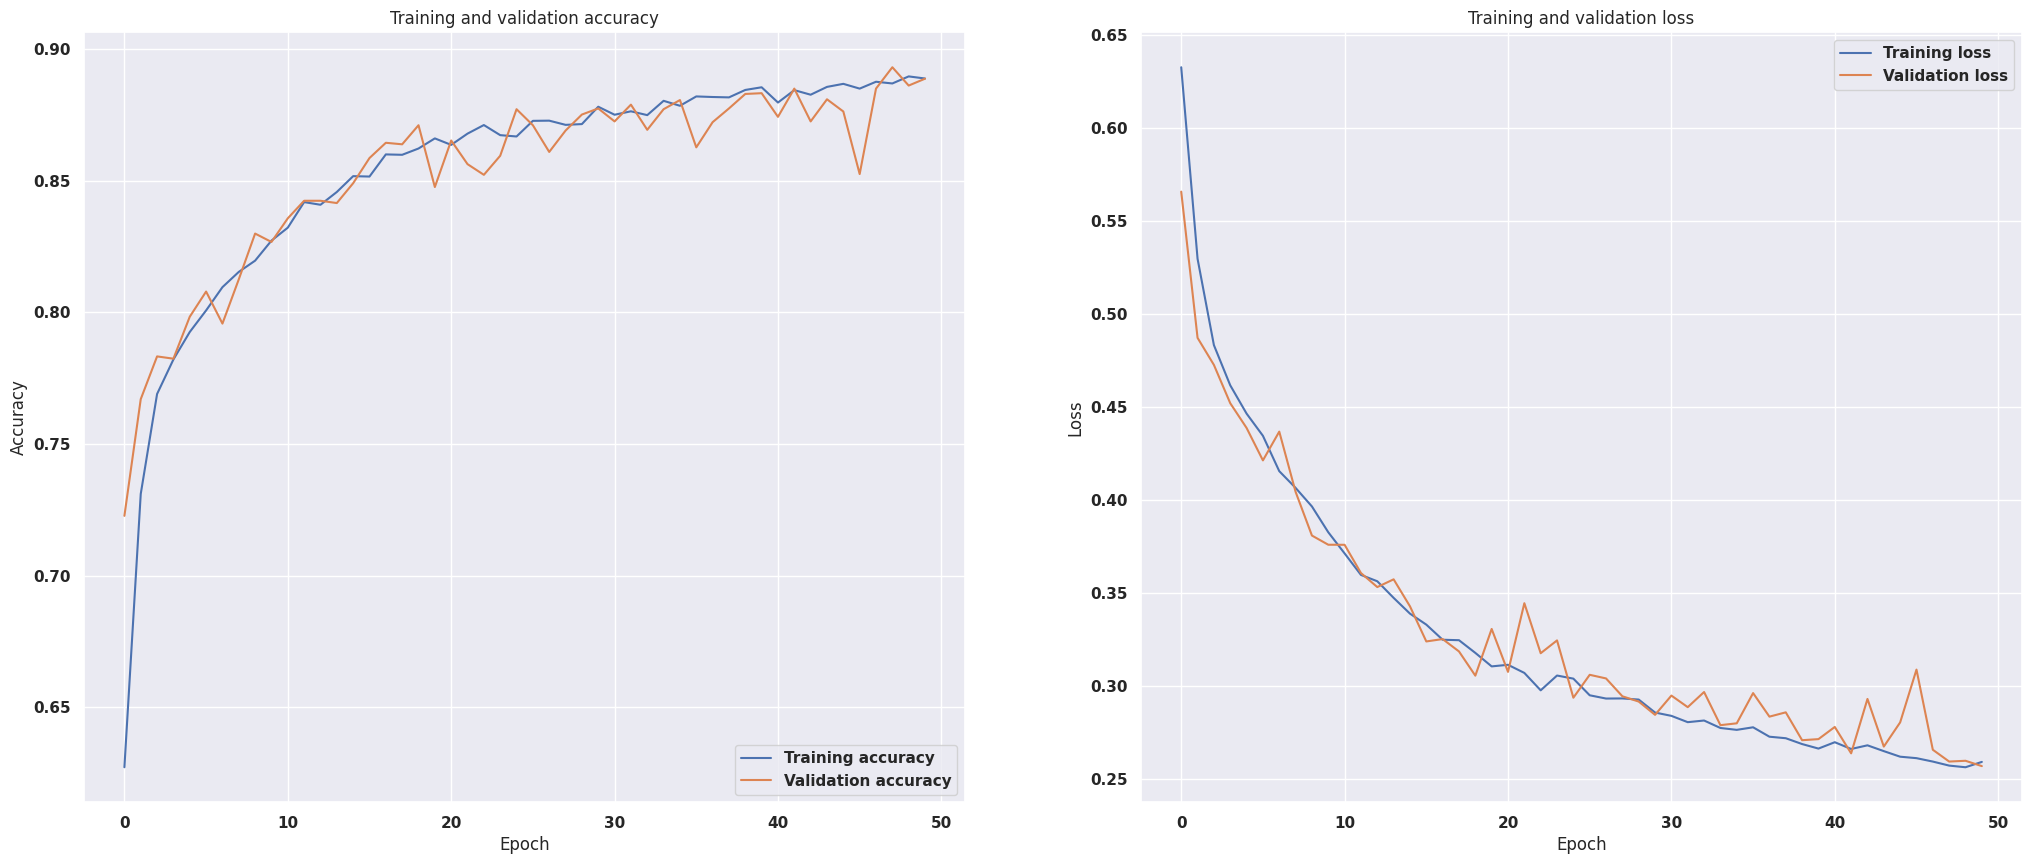

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)

plt.figure(figsize=(25,10))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.plot(history.history['accuracy'], label='Training accuracy')
ax1.plot(history.history['val_accuracy'], label = 'Validation accuracy')
ax1.set_title("Training and validation accuracy")
ax1.set(xlabel='Epoch', ylabel='Accuracy')
ax1.legend(loc='lower right')

ax2.plot(history.history['loss'], label='Training loss')
ax2.plot(history.history['val_loss'], label='Validation loss')
ax2.set_title("Training and validation loss")
ax2.set(xlabel='Epoch', ylabel='Loss')
ax2.legend(loc='upper right')

The network weights from the best model are retreived

108/108 - 0s - loss: 0.2063 - accuracy: 0.9157 - auc: 0.9752 - 356ms/epoch - 3ms/step
model_checkpoints/model-auc0.9752-epoch005.h5


Text(0, 0.5, 'Precision')

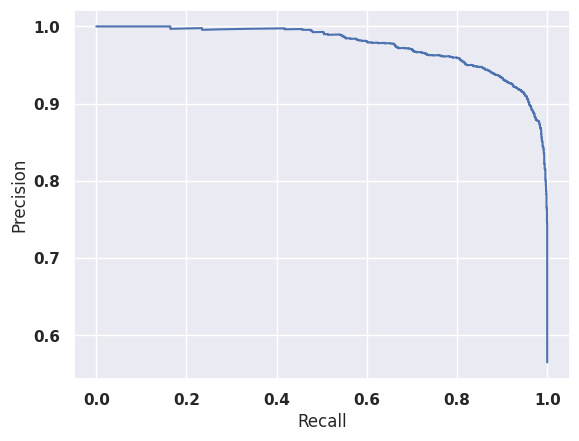

In [ ]:
test_loss, test_acc, aucc = best_model.evaluate(X_test,  y_test, verbose=2)

! ls -1 model_checkpoints/*model*.h5 | sort -n | tail -n 1
!cp $(ls -1 model_checkpoints/*model*.h5 | sort -n | tail -n 1) model_checkpoints/last.h5

best_model.load_weights("model_checkpoints/last.h5")
probs = best_model.predict_on_batch(X_test)

precision, recall, thresholds = precision_recall_curve(y_test, probs)

fig = plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")

Let's see the confusion matrix

108/108 [==============================] - 0s 2ms/step


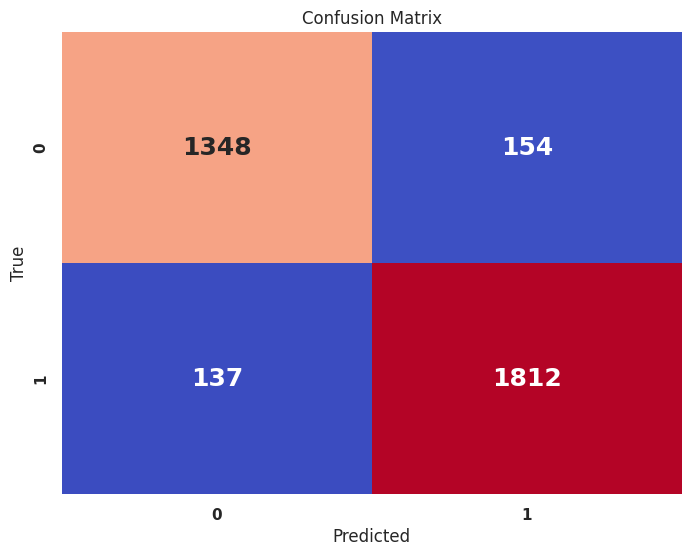

In [ ]:
from sklearn.metrics import confusion_matrix

y_test_binary = (y_test > 0.5).astype(int)
y_pred = best_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

confusion_mat = confusion_matrix(y_test_binary, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap="coolwarm", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

The model has improved, allowing it to go through a larger number of epochs and increasing the layers size.
There are quite good results looking at the confusion matrix.
There is still room for improvement, fixing the layers numbers, the optimizer and ideally increasing the dataset size which is not so large.
